In [1]:
import argparse
import os
from datetime import datetime
from os.path import join

import numpy as np
import torch
from torch.utils.data import DataLoader

from base_backup_0702_morning import AlternatingOptimizer, Use_original, Unlearn
from clip import clip
from datasets import Clipfeature, Clipfeature_check, initialize_data
from defaults import _C as cfg
from network import load_base_model
from network.clip import evaluate_clip
from utils import initialize_experiment

args = argparse.Namespace(
    root='./datasets',
    config_file="configs/debias_waterbird_mode.yaml",
    lr = 1e-4,
    epochs = 10,
    nolabel = False,
    mode = 'sud',
    bs = 256
)

cfg.merge_from_file(args.config_file)
cfg.merge_from_list(['lr', args.lr])
cfg.num_workers = 2
random_seed = cfg.seed
torch.manual_seed(random_seed)
np.random.seed(random_seed)

print('tau_i: %.2f tau_z_i: %.2f tau_t: %.2f tau_z_t: %.2f' % (cfg.tau_i, cfg.tau_z_i, cfg.tau_t, cfg.tau_z_t))

# ----------------------------------------------------------
# loading model /label for zero-shot testing
# ----------------------------------------------------------
base_model_args = cfg.load_base_model.split('_')
base_model_components = load_base_model(base_model_args, cfg, clip=clip)
base_model, base_transform, get_embeddings, get_dataset_embeddings, get_zeroshot_predictions = base_model_components
uo = Use_original(base_model, base_transform, get_embeddings, get_dataset_embeddings, get_zeroshot_predictions, cfg)
if cfg.dataset == 'waterbirds':
    text_descriptions = ['This is a picture of a landbird.', 'This is a picture of a waterbird.']
else:
    text_descriptions = ['A photo of a celebrity with dark hair.', 'A photo of a celebrity with blond hair.']
# ----------------------------------------------------------
# loading model /label for original data
# ----------------------------------------------------------
args.dataset, args.arch, args.num_workers, args.verbose = cfg.dataset, cfg.load_base_model.split('_')[-1], 2, False
args.load_base_model, args.device, args.embeddings_dir = cfg.load_base_model, cfg.device, 'new_test_'
os.makedirs(args.embeddings_dir, exist_ok=True)
load_dataloaders = initialize_data(args)
dataloaders_base = load_dataloaders(args, train_shuffle=False, transform=base_transform)

train_loader_base, val_loader_base, test_loader_base = dataloaders_base
splits = ['train', 'val', 'test']

initialize_experiment(cfg)
os.makedirs('new_test', exist_ok=True)
dataset_embeddings = {}
for dix, split in enumerate(splits):
    dataset_embeddings[split] = get_dataset_embeddings(base_model, dataloaders_base[dix], args, split=split)

# ----------------------------------------------------------
# loading train / test sets
# ----------------------------------------------------------

trainset = Clipfeature_check('train', cfg)
traindata = DataLoader(trainset, batch_size=trainset.__len__(), shuffle=False)
for i, (imfeat_train, textfeat_train, labels_train_y, labels_train_s, labels_train_y_gt) in enumerate(traindata):
    y_train = ((labels_train_y_gt + 1) / 2)[:, 1].int()
    s_train = ((labels_train_s + 1) / 2)[:, 1].int()
    
testset = Clipfeature_check('test', cfg)
testdata = DataLoader(testset, batch_size=testset.__len__(), shuffle=False)
# ----------------------------------------------------------

query_embeddings = get_embeddings(text_descriptions, base_model, cfg, normalize=True, verbose=False)
text_embeddings = query_embeddings.float().to(cfg.device)

for i, (_, _, labels_train_y, labels_train_s, labels_train_y_gt) in enumerate(traindata):
    iter = args.epochs if cfg.nolabel else args.epochs

    model = Unlearn(cfg, uo, train_loader_base, val_loader_base, get_zeroshot_predictions, no_label=cfg.nolabel)
    model.info(text_embeddings, labels_train_y, test_loader_base, testdata)
    # model.train_sud_loss(iter, True) if cfg.mode == 'sud' else model.train(iter)

tau_i: 0.70 tau_z_i: 0.70 tau_t: 0.10 tau_z_t: 0.10
root: /home/connor/.cache/clip
-> Number of parameters: 427616513.0
-> Dataset:         waterbirds
---
-> Number of parameters: 786432
unlearn target parameter : 786432


In [2]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def make_plot(ori_feature, adv_feature=None, ori_prediction=None, adv_prediction=None, wrong_marker=True, only_ori_feature=False, ori_pca=False, only_bias=False):
    batch, dim = ori_feature.shape
    markers = ['o', '^']
    sample_features = torch.cat((ori_feature.cpu().detach(), adv_feature.cpu().detach()), dim=0)
    pca_2d = PCA(n_components=2)
    reduced_features = pca_2d.fit_transform(sample_features)
    reduced_samples_2d = pca_2d.transform(sample_features)

    ori_feature_pca = reduced_samples_2d[:batch, :]
    adv_feature_pca = reduced_samples_2d[batch:, :] if not only_ori_feature else None
    y = y_train[:batch]
    s = s_train[:batch]
    styles = {
        'class_0_best_right': {'marker': 'o', 'facecolor': 'blue', 'edgecolor': 'none'},
        'class_0_best_wrong': {'marker': 'o', 'facecolor': 'blue', 'edgecolor': 'none'},
        'class_0_worst_right': {'marker': 'o', 'facecolor': 'none', 'edgecolor': 'blue'},
        'class_0_worst_wrong': {'marker': 'o', 'facecolor': 'none', 'edgecolor': 'blue'},
        'class_1_best_right': {'marker': '^', 'facecolor': 'none', 'edgecolor': 'red'},
        'class_1_best_wrong': {'marker': '^', 'facecolor': 'none', 'edgecolor': 'red'},
        'class_1_worst_right': {'marker': '^', 'facecolor': 'red', 'edgecolor': 'none'},
        'class_1_worst_wrong': {'marker': '^', 'facecolor': 'red', 'edgecolor': 'none'},
        'adv_best': {'color': 'orange', 'linewidth': 1.5},
        'adv_worst': {'color': 'purple', 'linewidth': 1.5}
    }
    print('original_target',(~(ori_prediction == y)).sum())
    
    # Calculate group indices
    group_indices_ori = {
        'class_0_best_right': np.array([(yi == False) and (si == False) and (oi == False) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_0_best_wrong': np.array([(yi == False) and (si == False) and (oi == True) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_0_worst_right': np.array([(yi == False) and (si == True) and (oi == False) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_0_worst_wrong': np.array([(yi == False) and (si == True) and (oi == True) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_1_best_right': np.array([(yi == True) and (si == True) and (oi == True) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_1_best_wrong': np.array([(yi == True) and (si == True) and (oi == False) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_1_worst_right': np.array([(yi == True) and (si == False) and (oi == True) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_1_worst_wrong': np.array([(yi == True) and (si == False) and (oi == False) for yi, si, oi in zip(y, s, ori_prediction)])
    }
    
    
    # Calculate group indices for adv_feature_pca
    group_indices_adv = {
        'class_0_best_right': np.array([(yi == False) and (si == False) and (ai == False) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_0_best_wrong': np.array([(yi == False) and (si == False) and (ai == True) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_0_worst_right': np.array([(yi == False) and (si == True) and (ai == False) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_0_worst_wrong': np.array([(yi == False) and (si == True) and (ai == True) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_1_best_right': np.array([(yi == True) and (si == True) and (ai == True) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_1_best_wrong': np.array([(yi == True) and (si == True) and (ai == False) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_1_worst_right': np.array([(yi == True) and (si == False) and (ai == True) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_1_worst_wrong': np.array([(yi == True) and (si == False) and (ai == False) for yi, si, ai in zip(y, s, adv_prediction)])
    }
    
    plt.figure(figsize=(10, 8))
    used_labels = set()

    def plot_with_overlay(data, indices, marker_style, label_text, overlay_color='purple', wrong_case=True):
        if label_text not in used_labels:
            plt.scatter(data[indices, 0], data[indices, 1], 
                        marker=marker_style['marker'], 
                        facecolors=marker_style['facecolor'], 
                        edgecolors=marker_style['edgecolor'], 
                        label=label_text)
            used_labels.add(label_text)
        else:
            plt.scatter(data[indices, 0], data[indices, 1],  
                        marker=marker_style['marker'], 
                        facecolors=marker_style['facecolor'], 
                        edgecolors=marker_style['edgecolor'])
        if wrong_case and wrong_marker:
            plt.scatter(data[indices, 0], data[indices, 1], 
                        marker='s', s=150, facecolors='none', edgecolors=overlay_color, alpha=0.5)


    for key, indices in group_indices_ori.items():
        wrong_case = 'wrong' in key
        base_key = '_'.join(key.split('_')[:3])
        label_text = f'{base_key.replace("_", " ")} ori_group'
        plot_with_overlay(ori_feature_pca, indices, styles[key], label_text,  wrong_case=wrong_case)

    if not only_ori_feature:
        if not only_bias:
            for key in ['class_0_best_right', 'class_0_best_wrong', 'class_1_best_right', 'class_1_best_wrong']:
                indices = group_indices_adv[key]
                base_key = '_'.join(key.split('_')[:3])
                label_text = f'{base_key.replace("_", " ")} adv'
                plt.scatter(adv_feature_pca[indices, 0], adv_feature_pca[indices, 1], 
                            marker=styles[key]['marker'], 
                            facecolors='none' if 'class_0' in key else styles['adv_best']['color'],
                            edgecolors=styles['adv_best']['color'] if 'class_0' in key else 'none', 
                            linewidths=styles['adv_best']['linewidth'], 
                            label=label_text if label_text not in used_labels else '')
                if label_text not in used_labels:
                    used_labels.add(label_text)
                if 'wrong' in key and wrong_marker:
                    plt.scatter(adv_feature_pca[indices, 0], adv_feature_pca[indices, 1], 
                                marker='s', s=150, facecolors='none', edgecolors='green', alpha=0.5)

        for key in ['class_0_worst_right', 'class_0_worst_wrong', 'class_1_worst_right', 'class_1_worst_wrong']:
            indices = group_indices_adv[key]
            base_key = '_'.join(key.split('_')[:3])
            label_text = f'{base_key.replace("_", " ")} adv'
            plt.scatter(adv_feature_pca[indices, 0], adv_feature_pca[indices, 1], 
                        marker=styles[key]['marker'], 
                        facecolors='none' if 'class_0' in key else styles['adv_worst']['color'],
                        edgecolors=styles['adv_worst']['color'] if 'class_0' in key else 'none', 
                        linewidths=styles['adv_worst']['linewidth'], 
                        label=label_text if label_text not in used_labels else '')
            if label_text not in used_labels:
                used_labels.add(label_text)
            if 'wrong' in key and wrong_marker:
                plt.scatter(adv_feature_pca[indices, 0], adv_feature_pca[indices, 1], 
                            marker='s', s=150, facecolors='none', edgecolors='green', alpha=0.5)

    

    plt.legend()
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('[PCA] Clip waterbird Vision Output Features')
    plt.show()

original_target tensor(25)


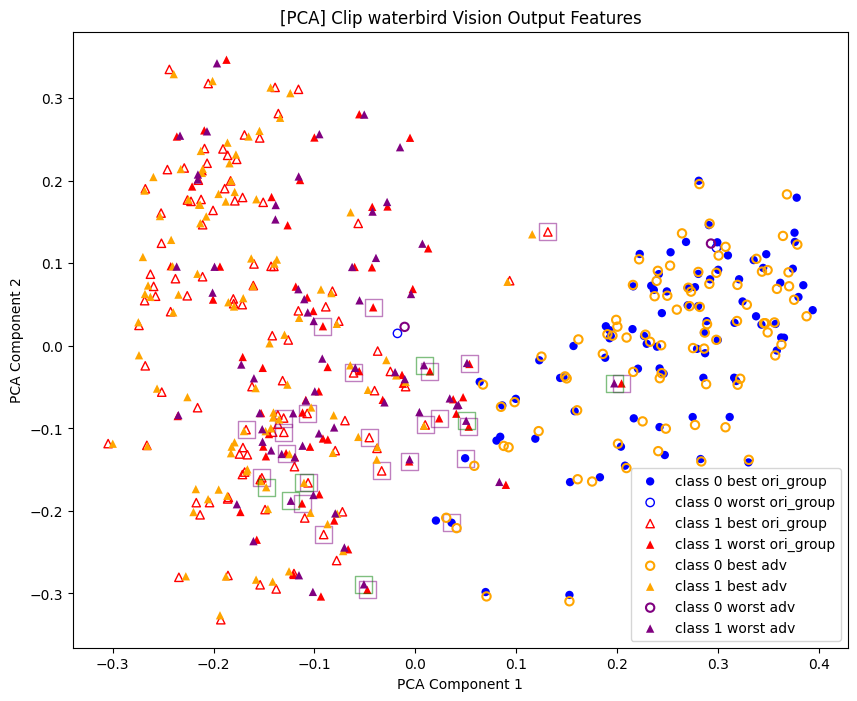

In [3]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=15, alpha=0.3, beta=0.9)
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu())
    break

original_target tensor(4)


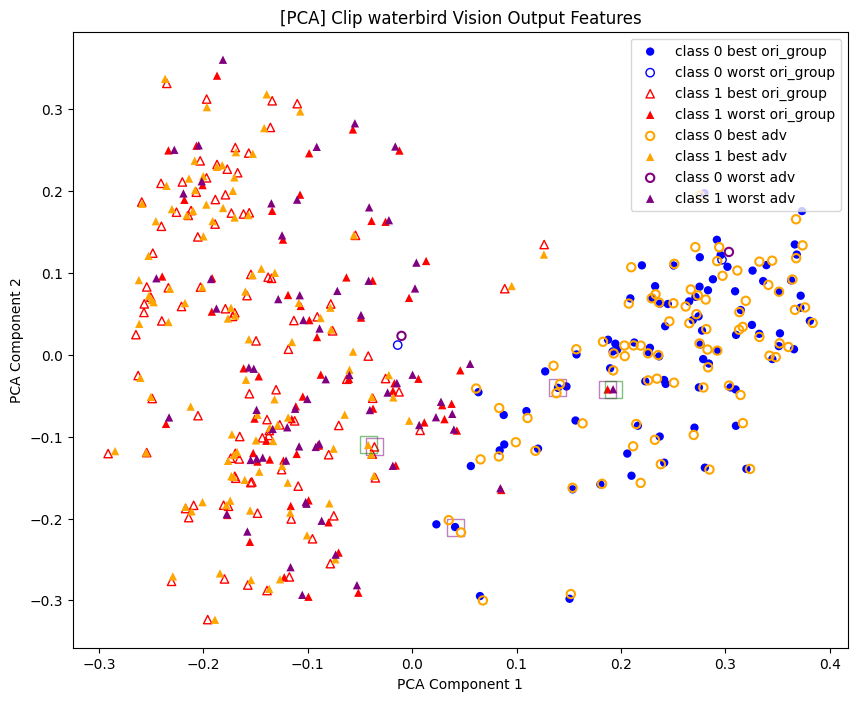

In [4]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=95, alpha=0.3, beta=0.9)
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu())
    break

original_target tensor(5)


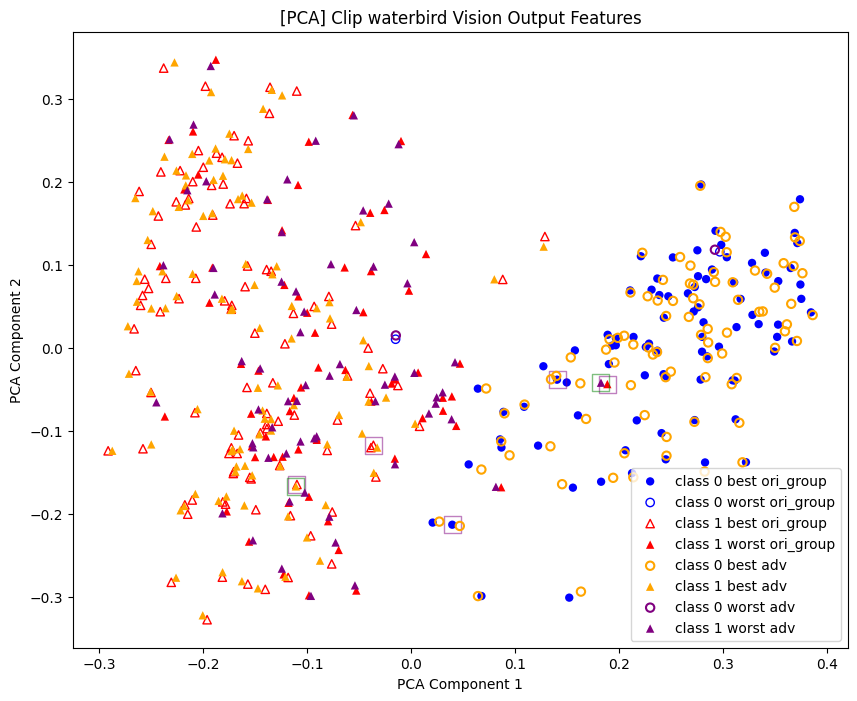

In [5]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=50, alpha=0.6, beta=0.9)
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu())
    break

In [6]:
ori_prediction

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [7]:
batch_y[:256]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

original_target tensor(155)


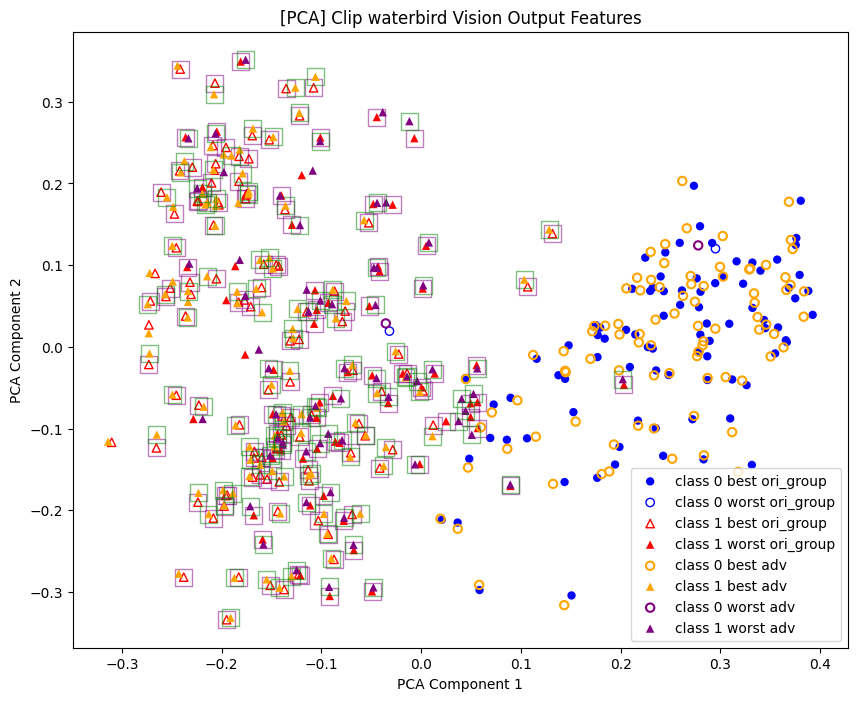

In [8]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=0, alpha=0.6, beta=0.5, mode='bafa', name='save_for_test_best_group')
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu())
    break

original_target tensor(22)


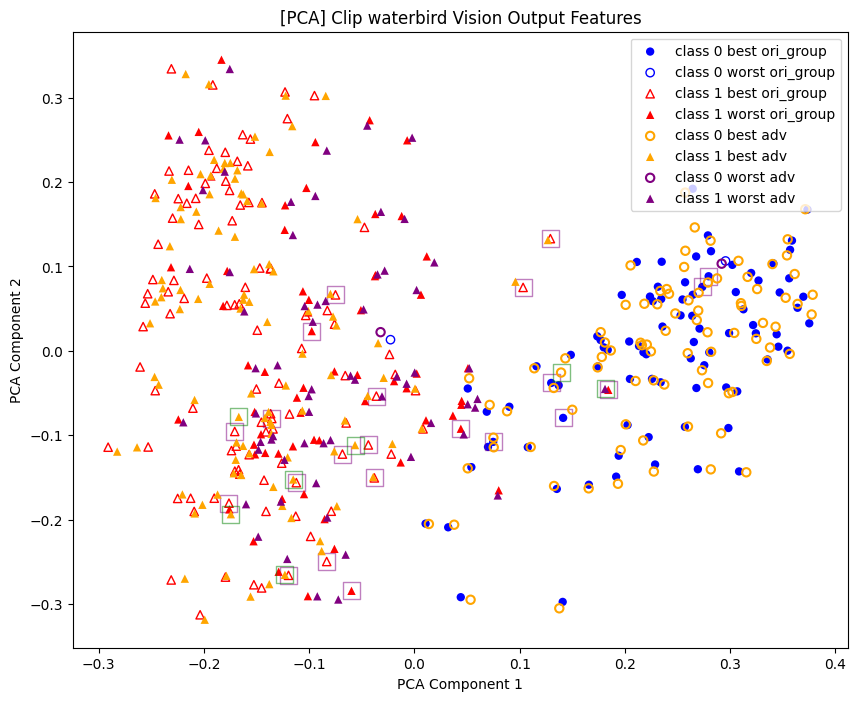

In [9]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=80, alpha=0.6, beta=0.5, mode='bafa', name='save_for_test_best_group')
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu())
    break

original_target tensor(123)


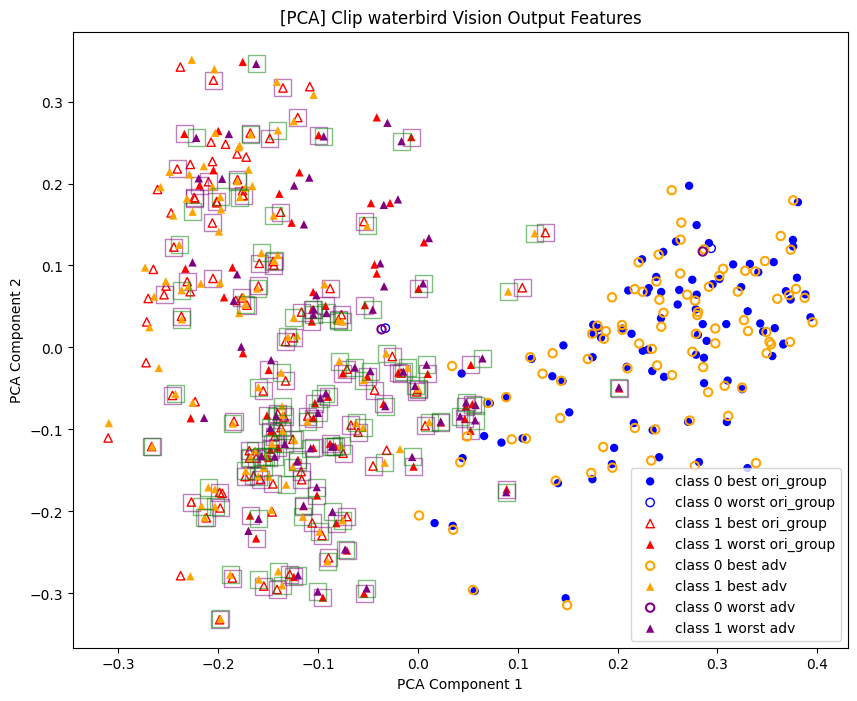

In [10]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=0, alpha=0.5, beta=0.9, mode='bafa', name='save_for_new_group')
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu(),wrong_marker=True)
    break

original_target tensor(10)


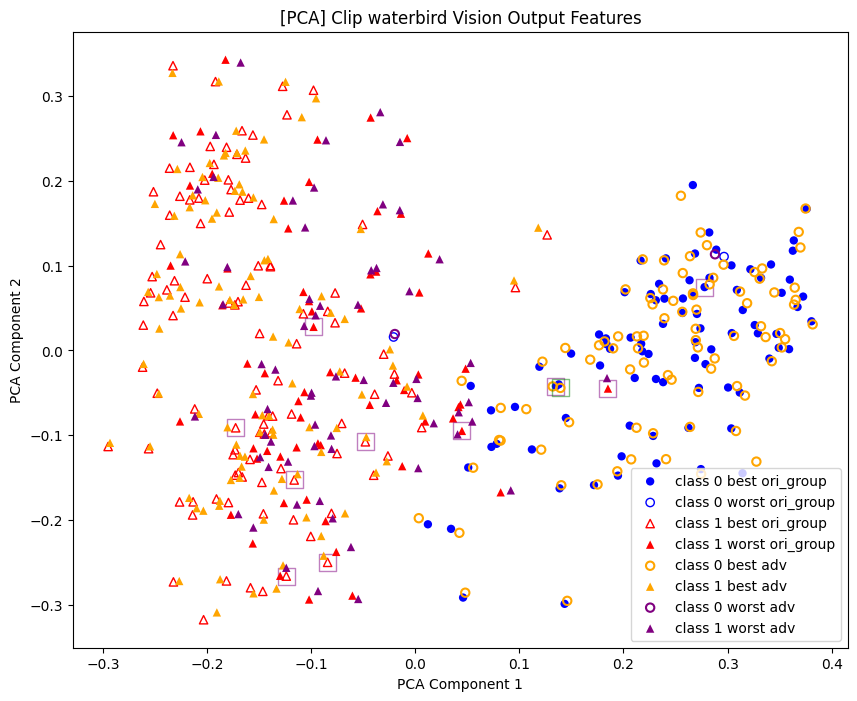

In [11]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=90, alpha=0.5, beta=0.9, mode='bafa', name='save_for_new_group')
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu())
    break

original_target tensor(103)


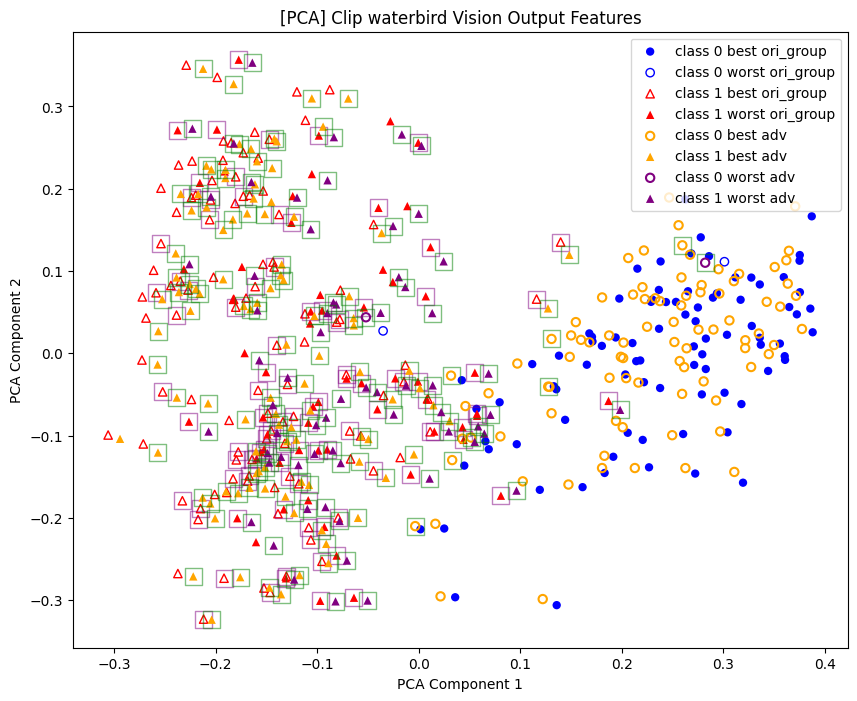

In [12]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_orginal_attack(batch_x, batch_y)
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.text_embeddings.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.text_embeddings.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu())
    break

original_target tensor(100)


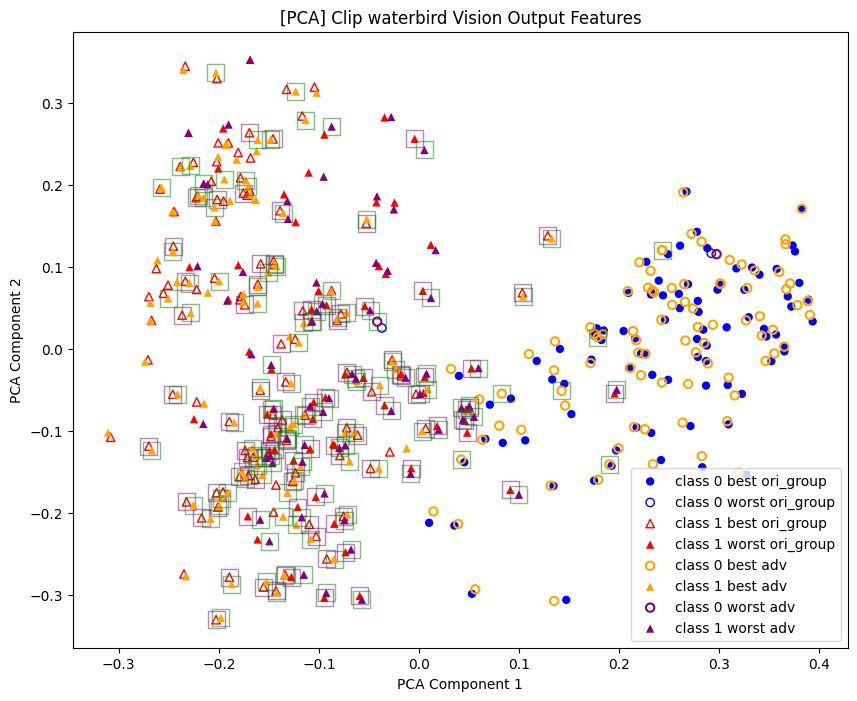

In [13]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=0, alpha=0.3, beta=0.9, mode='mse')
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu())
    break

original_target tensor(5)


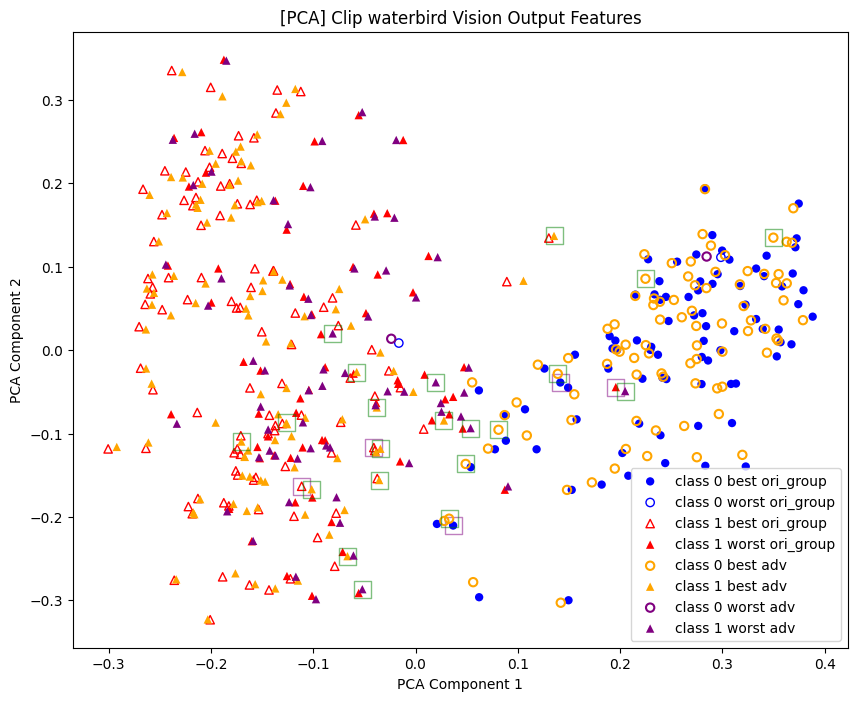

In [14]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=95, alpha=0.3, beta=0.9, mode='mse')
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu())
    break

original_target tensor(5)


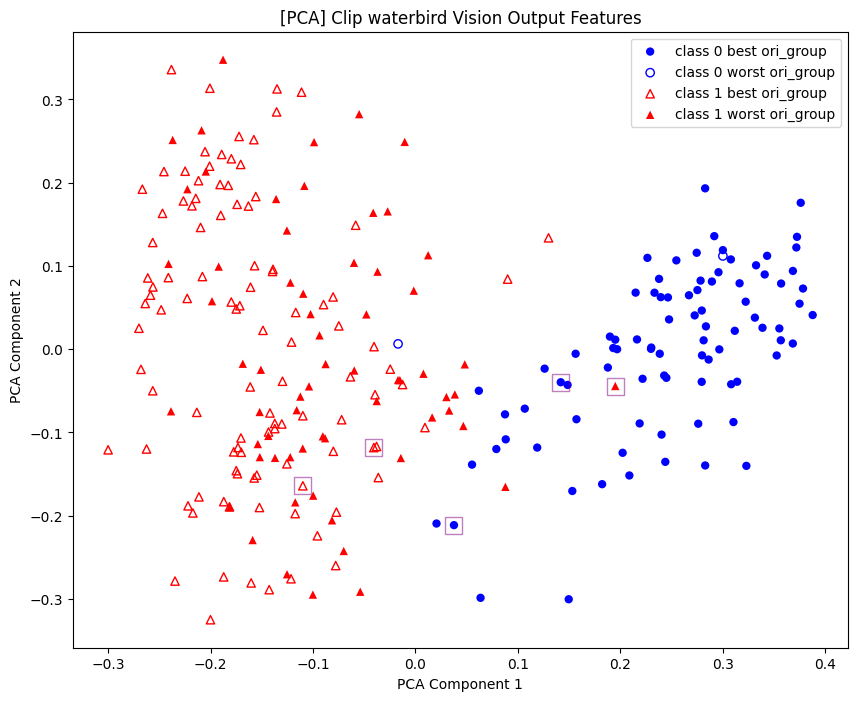

In [15]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=95, alpha=0.3, beta=0.9, mode='mse')
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu(), only_ori_feature=True)
    break

original_target tensor(7)


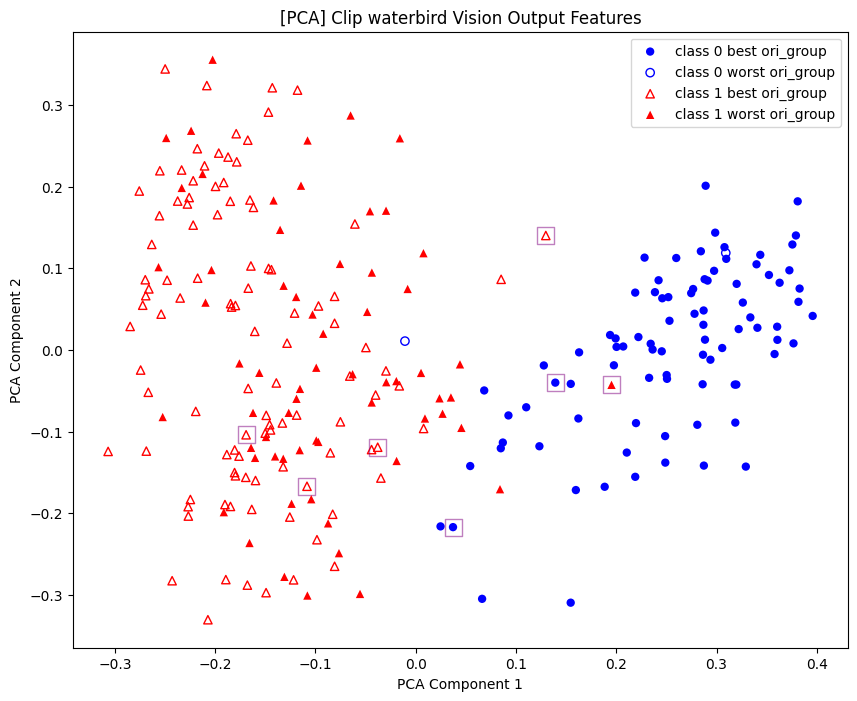

In [16]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=95, alpha=0.3, beta=0.9, mode='bafa')
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu(), only_ori_feature=True)
    break

original_target tensor(7)


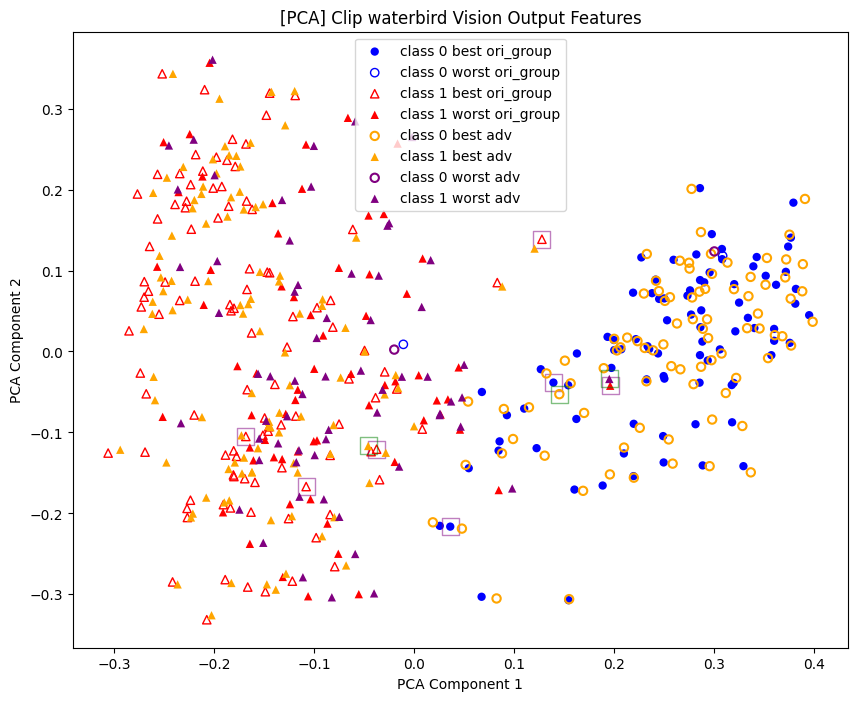

In [17]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=95, alpha=0.3, beta=0.9, mode='bafa')
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu())
    break

original_target tensor(19)


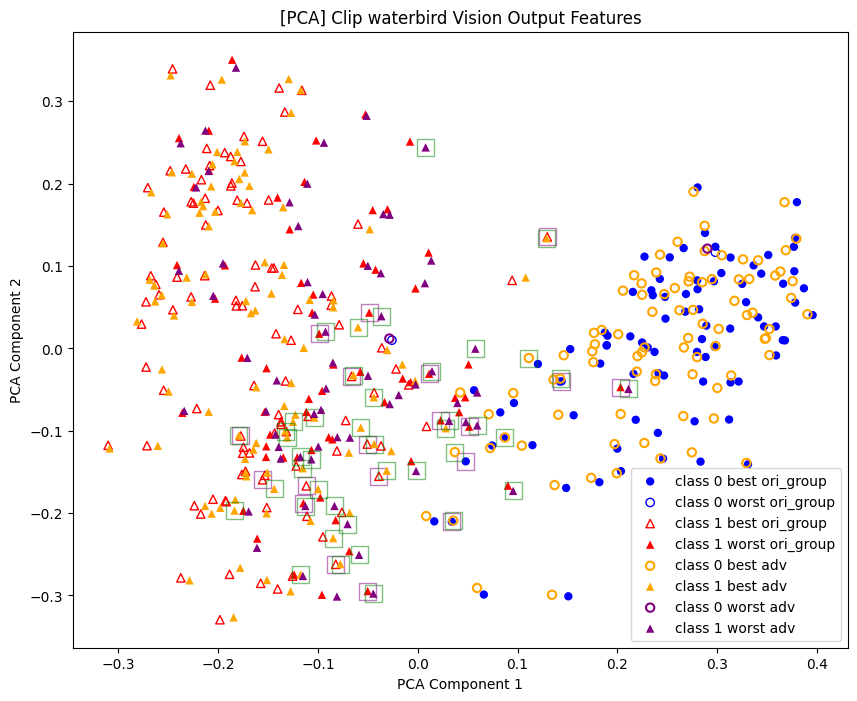

In [18]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=20, alpha=0.3, beta=0.9, mode='mse')
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu())
    break

original_target tensor(5)


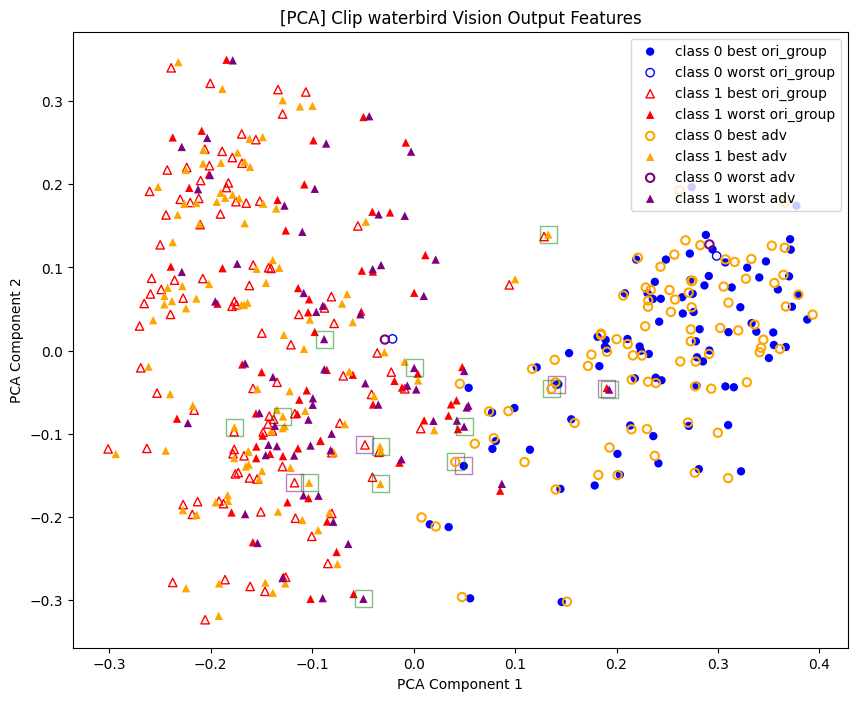

In [19]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=60, alpha=0.7, beta=0.9, mode='bafa_kl', name='save_for_new_group')
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu()) # , only_ori_feature=True
    break

original_target tensor(3)


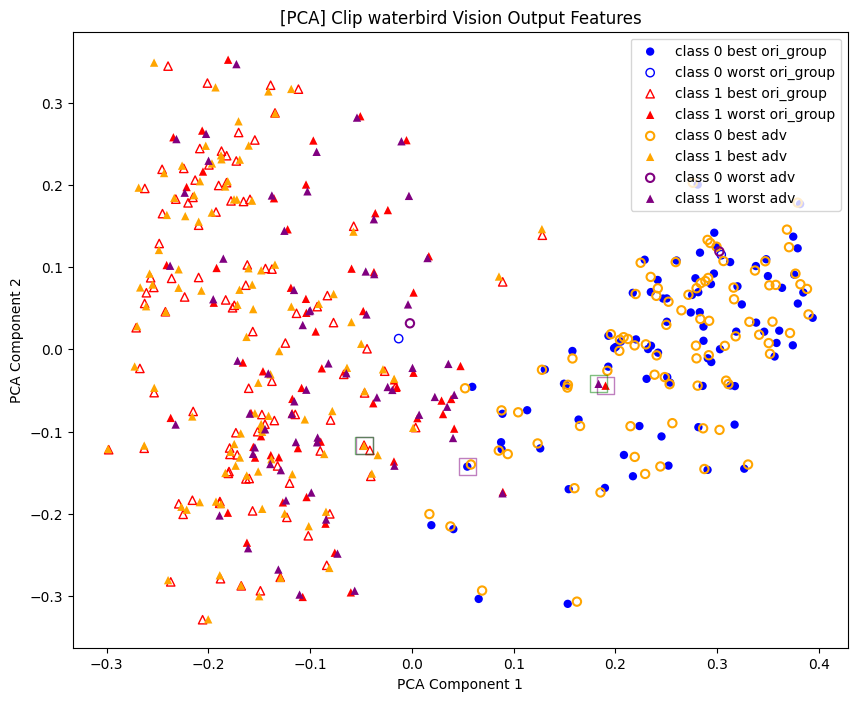

In [20]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    # student_layer95_0.7_0.9_bafa_0.3_0.0001_5.pth
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=95, alpha=0.7, beta=0.9, mode='bafa', name='save_for_0701am', bound=0.3,step=0.0001,iter=5)
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu(), only_ori_feature=False)
    break

original_target tensor(4)


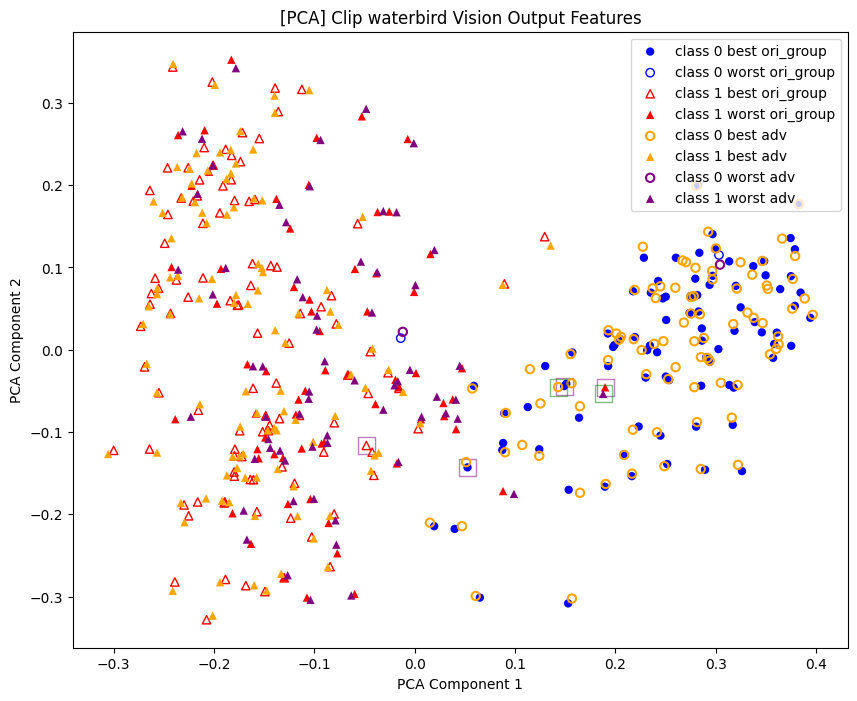

In [21]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    # student_layer95_0.7_0.9_bafa_0.3_0.0001_5.pth
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=95, alpha=0.7, beta=0.9, mode='bafa_mse', name='save_for_0701am', bound=0.3,step=0.001,iter=5)
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu(), only_ori_feature=False)
    break

original_target tensor(89)


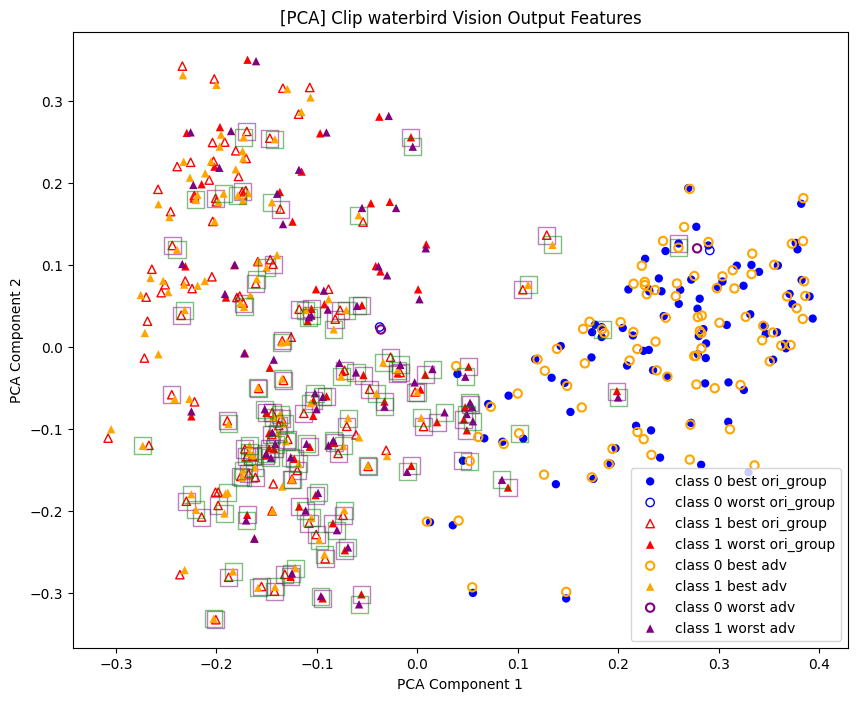

In [22]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=0, alpha=0.3, beta=0.9, mode='mse', name='save_for_0701am', bound=0.3,step=0.001,iter=5)
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu(), only_ori_feature=False)
    break

original_target tensor(7)


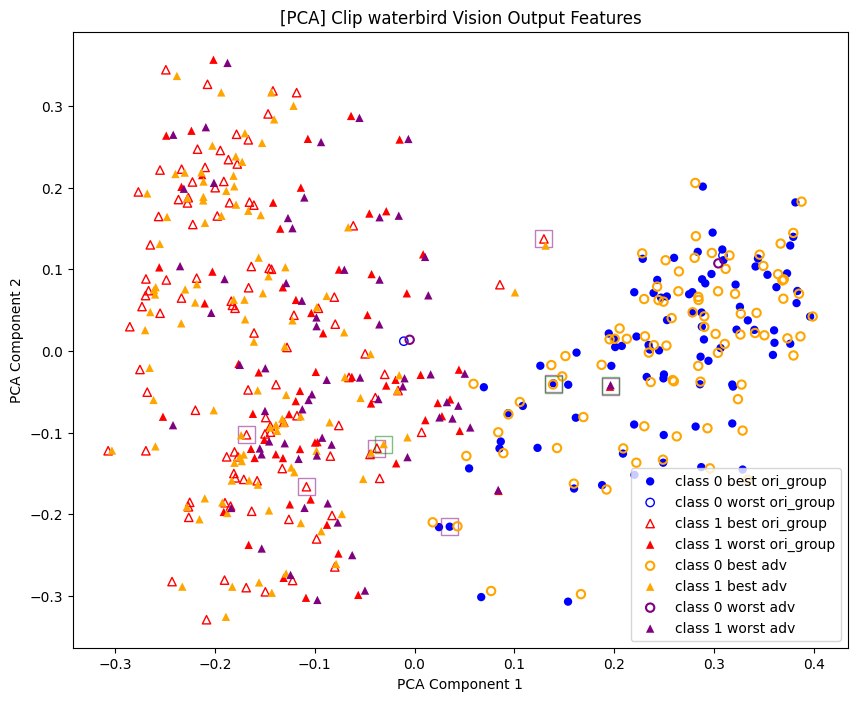

In [23]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=95, alpha=0.3, beta=0.9, mode='bafa', name='save_for_test')
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu(), only_ori_feature=False)
    break

original_target tensor(100)


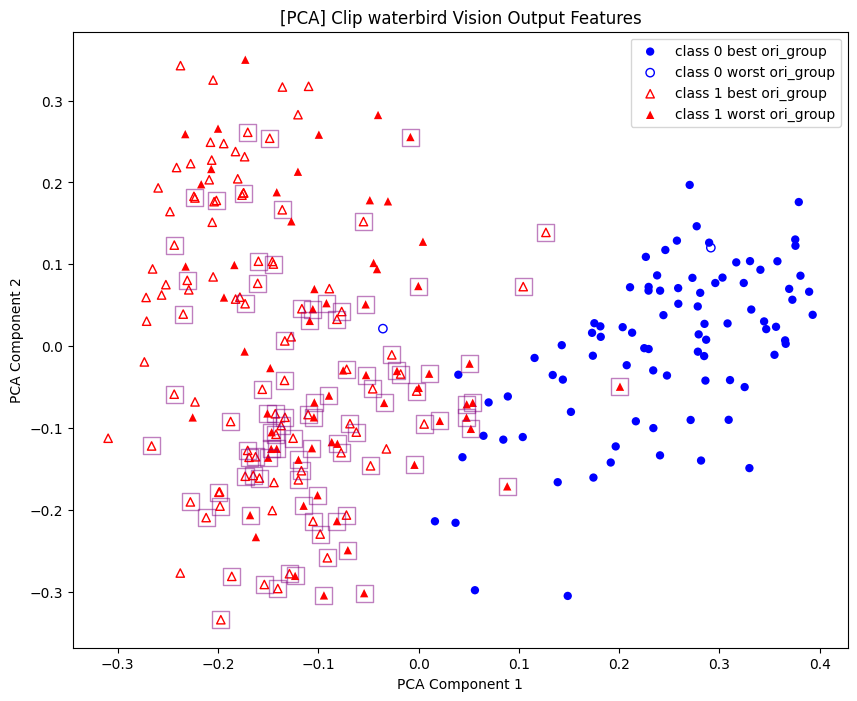

In [24]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=0, alpha=0.3, beta=0.9, mode='bafa', name='save_for_test')
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu(), only_ori_feature=True)
    break

original_target tensor(118)


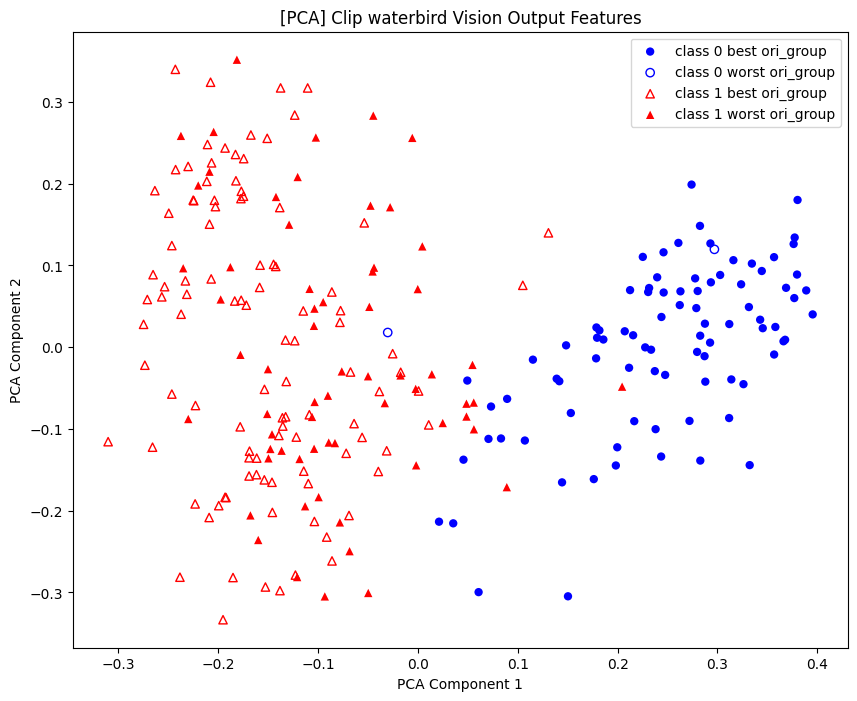

In [25]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=0, alpha=0.6, beta=0.9, mode='bafa', name='save_for_0701am', bound=0.3,step=0.01,iter=5)
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu(), only_ori_feature=True, wrong_marker=False)
    break

original_target tensor(83)


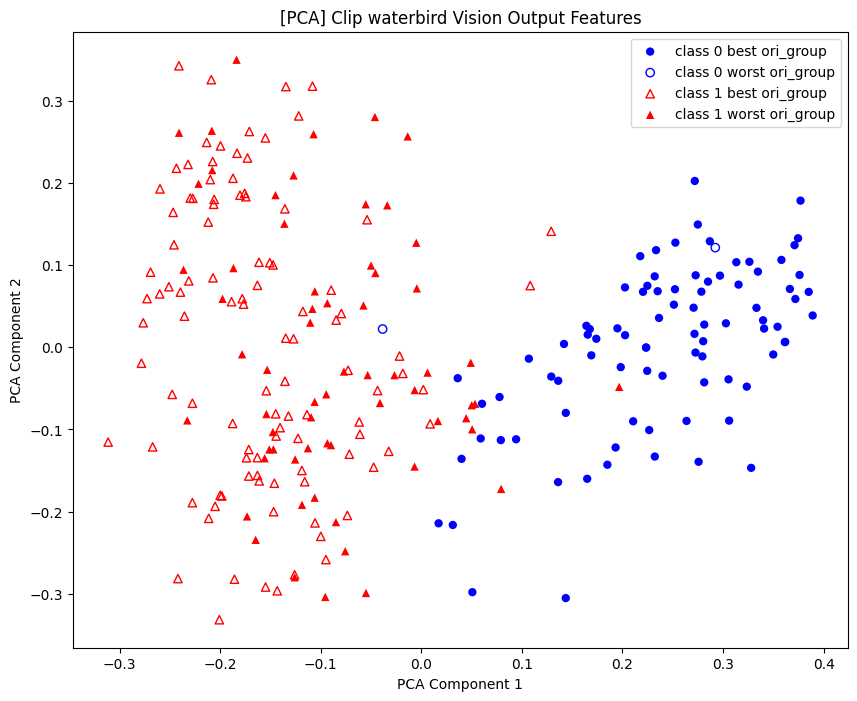

In [26]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=0, alpha=0.3, beta=0.9, mode='bafa', name='save_for_0701am', bound=0.3,step=0.01,iter=10)
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu(), only_ori_feature=True, wrong_marker=False)
    break

original_target tensor(103)


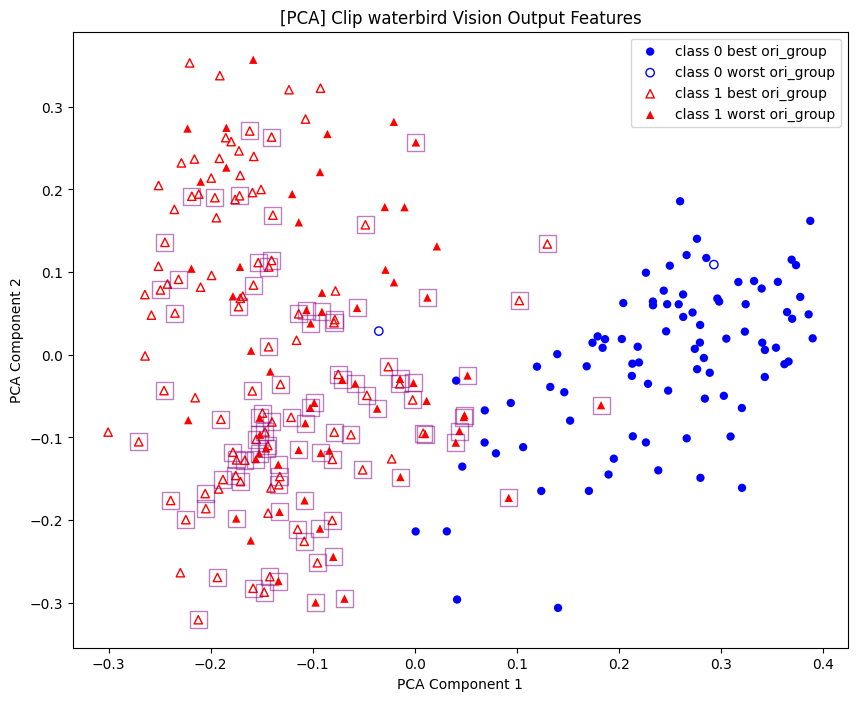

In [27]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=0, alpha=0.3, beta=0.9, mode='mse', name='save_for_0701am', bound=0.3,step=0.02,iter=5)
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu(), only_ori_feature=True, wrong_marker=True)
    break

original_target tensor(6)


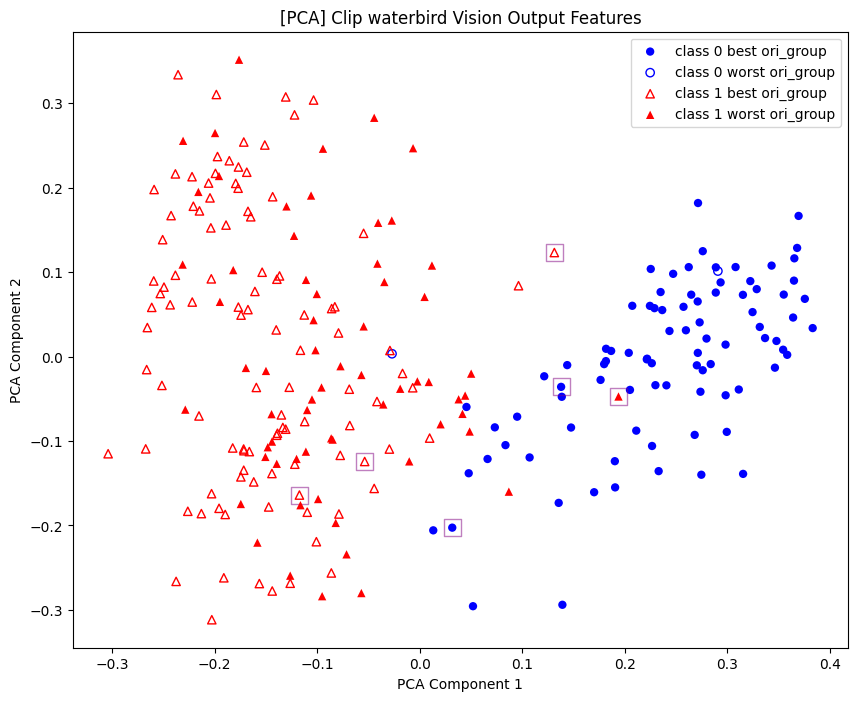

In [28]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=95, alpha=0.3, beta=0.9, mode='mse', name='save_for_0701am', bound=0.3,step=0.02,iter=5)
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu(), only_ori_feature=True, wrong_marker=True)
    break

In [40]:
# List 1: Bird-related sentences without the word "bird"
bird_related = [
    "This is a picture of short and strong feather",
    "This is a picture of waterproof feather",
    # "This is a picture of bird's eye",
    # "This is a picture of wing",
    # "This is a picture of head",
    # "This is a picture of a Fowl",
]

# List 2: Non-bird related sentences
non_bird_related = [
    "This is a picture with a land background",
    "This is a picture with a water background",
    # "This is a picture with a river background",
    # "This is a picture with a mountains background",
    # "This is a picture of a beach background",
    # "This is a picture of a ocean background",
]

label = ['This is a picture of a landbird.', 'This is a picture of a waterbird.']


In [30]:
# List 1: Bird-related sentences without the word "bird"
bird_related = [
    "This is a picture of feathers.",
    "This is a picture of a beak.",
    "This is a picture of bird's eye",
    "This is a picture of wing",
    "This is a picture of head",
    "This is a picture of a Fowl",
]

# List 2: Non-bird related sentences
non_bird_related = [
    "This is a picture of a forest",
    "This is a picture of a flowing river",
    "This is a picture of a city",
    "This is a picture of mountains",
    "This is a picture of a beach",
    "This is a picture of a ocean",
    "This is a picture with a water background",
    "This is a picture with a land background"
]

label = ['This is a picture of a landbird.', 'This is a picture of a waterbird.']


In [31]:
ori_prediction_old, adv_f_old = model.get_feature_with_attack(batch_x, batch_y, load_epoch=0, alpha=0.3, beta=0.9, mode='bafa2', name='save_for_0701am',bound=0.3,step=0.01,iter=10)
ori_prediction_new, adv_f_new = model.get_feature_with_attack(batch_x, batch_y, load_epoch=95, alpha=0.3, beta=0.9, mode='bafa2', name='save_for_0701am',bound=0.3,step=0.01,iter=10)

In [32]:
ori_prediction_old, adv_f_old = model.get_feature_with_attack(batch_x, batch_y, load_epoch=0, alpha=0.3, beta=0.9, mode='mse', name='save_for_0701am',bound=0.3,step=0.01,iter=10)
ori_prediction_new, adv_f_new = model.get_feature_with_attack(batch_x, batch_y, load_epoch=95, alpha=0.3, beta=0.9, mode='mse', name='save_for_0701am',bound=0.3,step=0.01,iter=10)

In [45]:
ori_prediction_old, adv_f_old = model.get_feature_with_attack(batch_x, batch_y, load_epoch=0, alpha=0.3, beta=0.9, mode='bafa', name='save_for_0701am',bound=0.3,step=0.01,iter=10)
#ori_prediction_new, adv_f_new = model.get_feature_with_attack(batch_x, batch_y, load_epoch=95, alpha=0.3, beta=0.9, mode='bafa', name='save_for_0701am',bound=0.3,step=0.01,iter=10)

In [50]:
ori_prediction_old, adv_f_old = model.get_feature_with_orginal_attack(batch_x, batch_y)

In [35]:
batch_y


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
import torch
import matplotlib.pyplot as plt

bird_related_feature = model.text_model.get_embeddings(bird_related, model.text_model.base_model, model.cfg)
non_bird_related_feature = model.text_model.get_embeddings(non_bird_related, model.text_model.base_model, model.cfg)
label_feature = model.text_model.get_embeddings(label, model.text_model.base_model, model.cfg)
bird_related_feature, non_bird_related_feature = bird_related_feature.detach().cpu(), non_bird_related_feature.detach().cpu()
ori_prediction_new, ori_prediction_old, adv_f_new, adv_f_old = ori_prediction_new.detach().cpu() , ori_prediction_old.detach().cpu(), adv_f_new.detach().cpu(), adv_f_old.detach().cpu() 

indices_0 = (batch_y == 0).nonzero(as_tuple=True)[0][:50]
indices_1 = (batch_y == 1).nonzero(as_tuple=True)[0][:50]
selected_indices = torch.cat((indices_0, indices_1))

ori_prediction_old = ori_prediction_old[selected_indices]
adv_f_old = adv_f_old[selected_indices]
labels = batch_y[selected_indices]

--------------------------------------------------
-> Text descriptions for zero-shot classification:
   - This is a picture of short and strong feather
   - This is a picture of waterproof feather
--------------------------------------------------
--------------------------------------------------
-> Text descriptions for zero-shot classification:
   - This is a picture with a land background
   - This is a picture with a water background
--------------------------------------------------
--------------------------------------------------
-> Text descriptions for zero-shot classification:
   - This is a picture of a landbird.
   - This is a picture of a waterbird.
--------------------------------------------------


In [52]:

# Calculate cosine similarity
similarity_old_bird = torch.nn.functional.cosine_similarity(ori_prediction_old.unsqueeze(1), bird_related_feature.unsqueeze(0), dim=2)
similarity_new_bird = torch.nn.functional.cosine_similarity(ori_prediction_new.unsqueeze(1), bird_related_feature.unsqueeze(0), dim=2)
similarity_old_non_bird = torch.nn.functional.cosine_similarity(ori_prediction_old.unsqueeze(1), non_bird_related_feature.unsqueeze(0), dim=2)
similarity_new_non_bird = torch.nn.functional.cosine_similarity(ori_prediction_new.unsqueeze(1), non_bird_related_feature.unsqueeze(0), dim=2)
similarity_old_label = torch.nn.functional.cosine_similarity(ori_prediction_old.unsqueeze(1), label_feature.unsqueeze(0), dim=2)
similarity_new_label = torch.nn.functional.cosine_similarity(ori_prediction_new.unsqueeze(1), label_feature.unsqueeze(0), dim=2)

similarity_old_bird_adv = torch.nn.functional.cosine_similarity(adv_f_old.unsqueeze(1), bird_related_feature.unsqueeze(0), dim=2)
similarity_new_bird_adv = torch.nn.functional.cosine_similarity(adv_f_new.unsqueeze(1), bird_related_feature.unsqueeze(0), dim=2)
similarity_old_non_bird_adv = torch.nn.functional.cosine_similarity(adv_f_old.unsqueeze(1), non_bird_related_feature.unsqueeze(0), dim=2)
similarity_new_non_bird_adv = torch.nn.functional.cosine_similarity(adv_f_new.unsqueeze(1), non_bird_related_feature.unsqueeze(0), dim=2)
similarity_old_label_adv = torch.nn.functional.cosine_similarity(adv_f_old.unsqueeze(1), label_feature.unsqueeze(0), dim=2)
similarity_new_label_adv = torch.nn.functional.cosine_similarity(adv_f_new.unsqueeze(1), label_feature.unsqueeze(0), dim=2)


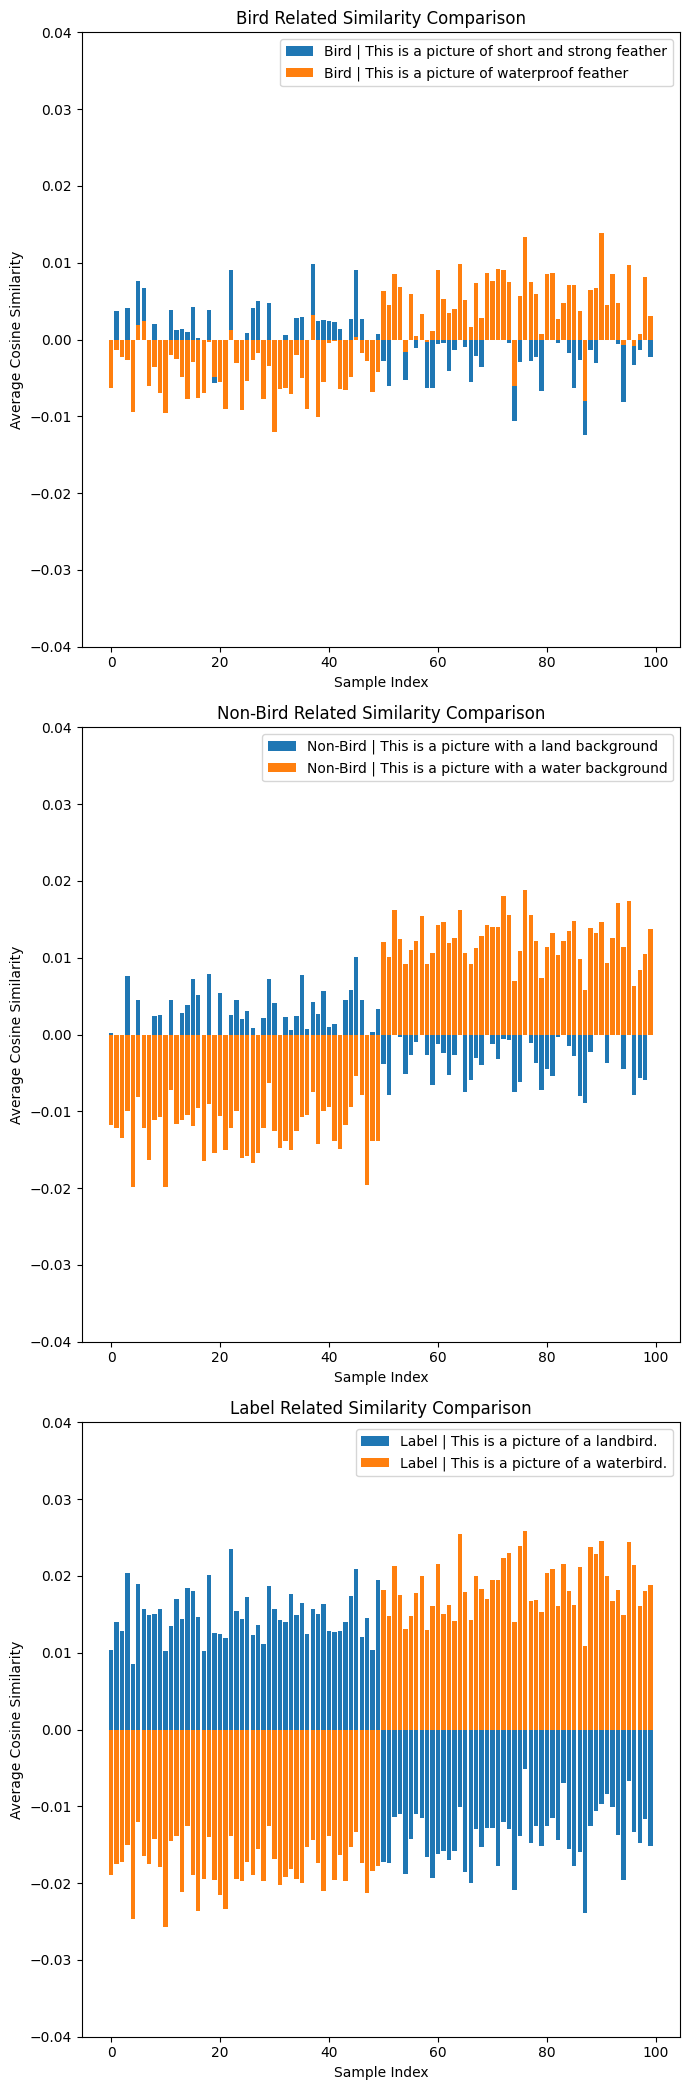

In [53]:
# 코사인 유사도 계산
similarity_old_bird = torch.nn.functional.cosine_similarity(ori_prediction_old.unsqueeze(1), bird_related_feature.unsqueeze(0), dim=2)
similarity_old_non_bird = torch.nn.functional.cosine_similarity(ori_prediction_old.unsqueeze(1), non_bird_related_feature.unsqueeze(0), dim=2)
similarity_old_label = torch.nn.functional.cosine_similarity(ori_prediction_old.unsqueeze(1), label_feature.unsqueeze(0), dim=2)

similarity_old_bird_adv = torch.nn.functional.cosine_similarity(adv_f_old.unsqueeze(1), bird_related_feature.unsqueeze(0), dim=2)
similarity_old_non_bird_adv = torch.nn.functional.cosine_similarity(adv_f_old.unsqueeze(1), non_bird_related_feature.unsqueeze(0), dim=2)
similarity_old_label_adv = torch.nn.functional.cosine_similarity(adv_f_old.unsqueeze(1), label_feature.unsqueeze(0), dim=2)

# 평균 유사도 계산

relative_similarity_bird = similarity_old_bird - similarity_old_bird_adv
relative_similarity_non_bird = similarity_old_non_bird - similarity_old_non_bird_adv
relative_similarity_label = similarity_old_label - similarity_old_label_adv

# 시각화
plt.figure(figsize=(7, 21))

# Bird 관련 유사도
plt.subplot(3, 1, 1)
for i in range(relative_similarity_bird.shape[1]):
    plt.bar(range(relative_similarity_bird.shape[0]), relative_similarity_bird[:, i].numpy(), label=f'Bird | {bird_related[i]}')
plt.xlabel('Sample Index')
plt.ylabel('Average Cosine Similarity')
plt.title('Bird Related Similarity Comparison')
plt.legend()
plt.ylim(-0.04, 0.04)

# Non-Bird 관련 유사도
plt.subplot(3, 1, 2)
for i in range(relative_similarity_non_bird.shape[1]):
    plt.bar(range(relative_similarity_non_bird.shape[0]), relative_similarity_non_bird[:, i].numpy(), label=f'Non-Bird | {non_bird_related[i]}')
plt.xlabel('Sample Index')
plt.ylabel('Average Cosine Similarity')
plt.title('Non-Bird Related Similarity Comparison')
plt.legend()
plt.ylim(-0.04, 0.04)

# Label 관련 유사도
plt.subplot(3, 1, 3)
for i in range(relative_similarity_label.shape[1]):
    plt.bar(range(relative_similarity_label.shape[0]), relative_similarity_label[:, i].numpy(), label=f'Label | {label[i]}')
plt.xlabel('Sample Index')
plt.ylabel('Average Cosine Similarity')
plt.title('Label Related Similarity Comparison')
plt.legend()
plt.ylim(-0.04, 0.04)
plt.savefig('sine_wave_plot.png')
plt.tight_layout()
plt.show()


In [39]:
stop

NameError: name 'stop' is not defined

In [ ]:
import torch
import matplotlib.pyplot as plt

# 코사인 유사도 계산
similarity_old_bird = torch.nn.functional.cosine_similarity(ori_prediction_old.unsqueeze(1), bird_related_feature.unsqueeze(0), dim=2)
similarity_old_non_bird = torch.nn.functional.cosine_similarity(ori_prediction_old.unsqueeze(1), non_bird_related_feature.unsqueeze(0), dim=2)
similarity_old_label = torch.nn.functional.cosine_similarity(ori_prediction_old.unsqueeze(1), label_feature.unsqueeze(0), dim=2)

similarity_old_bird_adv = torch.nn.functional.cosine_similarity(adv_f_old.unsqueeze(1), bird_related_feature.unsqueeze(0), dim=2)
similarity_old_non_bird_adv = torch.nn.functional.cosine_similarity(adv_f_old.unsqueeze(1), non_bird_related_feature.unsqueeze(0), dim=2)
similarity_old_label_adv = torch.nn.functional.cosine_similarity(adv_f_old.unsqueeze(1), label_feature.unsqueeze(0), dim=2)

# 평균 유사도 계산

relative_similarity_bird = similarity_old_bird - similarity_old_bird_adv
relative_similarity_non_bird = similarity_old_non_bird - similarity_old_non_bird_adv
relative_similarity_label = similarity_old_label - similarity_old_label_adv

# 시각화
plt.figure(figsize=(7, 21))

# Bird 관련 유사도
plt.subplot(3, 1, 1)
for i in range(relative_similarity_bird.shape[1]):
    plt.bar(range(relative_similarity_bird.shape[0]), relative_similarity_bird[:, i].numpy(), label=f'Bird | {bird_related[i]}')
plt.xlabel('Sample Index')
plt.ylabel('Average Cosine Similarity')
plt.title('Bird Related Similarity Comparison')
plt.legend()
plt.ylim(-0.04, 0.04)

# Non-Bird 관련 유사도
plt.subplot(3, 1, 2)
for i in range(relative_similarity_non_bird.shape[1]):
    plt.bar(range(relative_similarity_non_bird.shape[0]), relative_similarity_non_bird[:, i].numpy(), label=f'Non-Bird | {non_bird_related[i]}')
plt.xlabel('Sample Index')
plt.ylabel('Average Cosine Similarity')
plt.title('Non-Bird Related Similarity Comparison')
plt.legend()
plt.ylim(-0.04, 0.04)

# Label 관련 유사도
plt.subplot(3, 1, 3)
for i in range(relative_similarity_label.shape[1]):
    plt.bar(range(relative_similarity_label.shape[0]), relative_similarity_label[:, i].numpy(), label=f'Label | {label[i]}')
plt.xlabel('Sample Index')
plt.ylabel('Average Cosine Similarity')
plt.title('Label Related Similarity Comparison')
plt.legend()
plt.ylim(-0.04, 0.04)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Define columns
columns_bird = ['feathers', 'beak', 'eye', 'wing', 'head', 'fowl']
columns_non_bird = ['water', 'land', 'river', 'mountains', 'beach', 'ocean']
columns_label = ['landbird', 'waterbird']

# Create dataframes
df_bird = pd.DataFrame(relative_similarity_bird.numpy(), columns=columns_bird)
df_non_bird = pd.DataFrame(relative_similarity_non_bird.numpy(), columns=columns_non_bird)
df_label = pd.DataFrame(relative_similarity_label.numpy(), columns=columns_label)

df_bird_old = pd.DataFrame(similarity_old_bird.numpy(), columns=columns_bird)
df_non_bird_old = pd.DataFrame(similarity_old_non_bird.numpy(), columns=columns_non_bird)
df_label_old = pd.DataFrame(similarity_old_label.numpy(), columns=columns_label)

df_bird_adv = pd.DataFrame(similarity_old_bird_adv.numpy(), columns=columns_bird)
df_non_bird_adv = pd.DataFrame(similarity_old_non_bird_adv.numpy(), columns=columns_non_bird)
df_label_adv = pd.DataFrame(similarity_old_label_adv.numpy(), columns=columns_label)



# Add hierarchical columns
df_bird.columns = pd.MultiIndex.from_product([['relative_similarity'], ['bird_features'], df_bird.columns])
df_non_bird.columns = pd.MultiIndex.from_product([['relative_similarity'], ['non_bird_features'], df_non_bird.columns])
df_label.columns = pd.MultiIndex.from_product([['relative_similarity'], ['label_features'], df_label.columns])

df_bird_old.columns = pd.MultiIndex.from_product([['old_similarity'], ['bird_features'], df_bird_old.columns])
df_non_bird_old.columns = pd.MultiIndex.from_product([['old_similarity'], ['non_bird_features'], df_non_bird_old.columns])
df_label_old.columns = pd.MultiIndex.from_product([['old_similarity'], ['label_features'], df_label_old.columns])

df_bird_adv.columns = pd.MultiIndex.from_product([['advanced_similarity'], ['bird_features'], df_bird_adv.columns])
df_non_bird_adv.columns = pd.MultiIndex.from_product([['advanced_similarity'], ['non_bird_features'], df_non_bird_adv.columns])
df_label_adv.columns = pd.MultiIndex.from_product([['advanced_similarity'], ['label_features'], df_label_adv.columns])

# Concatenate dataframes horizontally
df_combined = pd.concat([df_bird, df_non_bird, df_label,
                         df_bird_old, df_non_bird_old, df_label_old,
                         df_bird_adv, df_non_bird_adv, df_label_adv], axis=1)

# Add class labels without hierarchical columns
df_combined['class'] = labels

# Save to CSV
df_combined.to_csv('./combined_relative_similarities2.csv', index=False)


In [ ]:
import torch
import matplotlib.pyplot as plt

# 코사인 유사도 계산
similarity_old_bird = torch.nn.functional.cosine_similarity(ori_prediction_old.unsqueeze(1), bird_related_feature.unsqueeze(0), dim=2)
similarity_old_non_bird = torch.nn.functional.cosine_similarity(ori_prediction_old.unsqueeze(1), non_bird_related_feature.unsqueeze(0), dim=2)
similarity_old_label = torch.nn.functional.cosine_similarity(ori_prediction_old.unsqueeze(1), label_feature.unsqueeze(0), dim=2)

similarity_old_bird_adv = torch.nn.functional.cosine_similarity(adv_f_old.unsqueeze(1), bird_related_feature.unsqueeze(0), dim=2)
similarity_old_non_bird_adv = torch.nn.functional.cosine_similarity(adv_f_old.unsqueeze(1), non_bird_related_feature.unsqueeze(0), dim=2)
similarity_old_label_adv = torch.nn.functional.cosine_similarity(adv_f_old.unsqueeze(1), label_feature.unsqueeze(0), dim=2)

# 평균 유사도 계산

relative_similarity_bird = similarity_old_bird - similarity_old_bird_adv
relative_similarity_non_bird = similarity_old_non_bird - similarity_old_non_bird_adv
relative_similarity_label = similarity_old_label - similarity_old_label_adv

relative_similarity_bird_result = (relative_similarity_bird[:,0] - relative_similarity_bird[:,1]).numpy()
relative_similarity_non_bird_result = (relative_similarity_non_bird[:,0] - relative_similarity_non_bird[:,1]).numpy()
relative_similarity_label_result = (relative_similarity_label[:,0] - relative_similarity_label[:,1]).numpy()


# 시각화
plt.figure(figsize=(7, 21))

# Bird 관련 유사도
plt.subplot(3, 1, 1)
plt.plot(relative_similarity_bird_result, label='Original Non-Bird Related', color='blue')

plt.xlabel('Sample Index')
plt.ylabel('Average Cosine Similarity')
plt.title('Bird Related Similarity Comparison')
plt.legend()
plt.ylim(-0.04, 0.04)

# Non-Bird 관련 유사도
plt.subplot(3, 1, 2)
plt.plot(relative_similarity_non_bird_result, label='Original Non-Bird Related', color='blue')
plt.xlabel('Sample Index')
plt.ylabel('Average Cosine Similarity')
plt.title('Non-Bird Related Similarity Comparison')
plt.legend()
plt.ylim(-0.04, 0.04)

# Label 관련 유사도
plt.subplot(3, 1, 3)
plt.plot(relative_similarity_label_result, label='Original Label Related', color='blue')
plt.xlabel('Sample Index')
plt.ylabel('Average Cosine Similarity')
plt.title('Label Related Similarity Comparison')
plt.legend()
plt.ylim(-0.04, 0.04)

plt.tight_layout()
plt.show()


In [ ]:
# Average similarities for bird related
mean_similarity_old_bird = similarity_old_bird.mean(dim=0).numpy()
mean_similarity_new_bird = similarity_new_bird.mean(dim=0).numpy()
mean_similarity_old_non_bird = similarity_old_non_bird.mean(dim=0).numpy()
mean_similarity_new_non_bird = similarity_new_non_bird.mean(dim=0).numpy()
mean_similarity_old_label = similarity_old_label.mean(dim=0).numpy()
mean_similarity_new_label = similarity_new_label.mean(dim=0).numpy()

mean_similarity_old_bird_adv = similarity_old_bird_adv.mean(dim=0).numpy()
mean_similarity_new_bird_adv = similarity_new_bird_adv.mean(dim=0).numpy()
mean_similarity_old_non_bird_adv = similarity_old_non_bird_adv.mean(dim=0).numpy()
mean_similarity_new_non_bird_adv = similarity_new_non_bird_adv.mean(dim=0).numpy()
mean_similarity_old_label_adv = similarity_old_label_adv.mean(dim=0).numpy()
mean_similarity_new_label_adv = similarity_new_label_adv.mean(dim=0).numpy()


# Creating labels for the x-axis
labels_bird = [f'Bird Feature {i}' for i in range(bird_related_feature.shape[0])]
labels_non_bird = [f'Non-Bird Feature {i}' for i in range(non_bird_related_feature.shape[0])]
label = [f'label Feature {i}' for i in range(label_feature.shape[0])]

# Combining bird and non-bird related labels and similarities
labels = labels_bird + labels_non_bird + label
mean_similarity_old = np.concatenate([mean_similarity_new_bird, mean_similarity_new_non_bird, mean_similarity_new_label])
mean_similarity_new = np.concatenate([mean_similarity_new_bird_adv, mean_similarity_new_non_bird_adv, mean_similarity_new_label_adv])

# Plotting the bar chart
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 7))
rects1 = ax.bar(x - width/2, mean_similarity_old, width, label='ori feature')
rects2 = ax.bar(x + width/2, mean_similarity_new, width, label='adv feature')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Features')
ax.set_ylabel('Mean Cosine Similarity')
ax.set_title('Mean Cosine Similarity by Feature and Prediction')
ax.set_xticks(x)
ax.set_ylim(0.12, 0.25)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
# Average similarities for bird related
mean_similarity_old_bird = similarity_old_bird.mean(dim=0).numpy()
mean_similarity_new_bird = similarity_new_bird.mean(dim=0).numpy()
mean_similarity_old_non_bird = similarity_old_non_bird.mean(dim=0).numpy()
mean_similarity_new_non_bird = similarity_new_non_bird.mean(dim=0).numpy()
mean_similarity_old_label = similarity_old_label.mean(dim=0).numpy()
mean_similarity_new_label = similarity_new_label.mean(dim=0).numpy()

mean_similarity_old_bird_adv = similarity_old_bird_adv.mean(dim=0).numpy()
mean_similarity_new_bird_adv = similarity_new_bird_adv.mean(dim=0).numpy()
mean_similarity_old_non_bird_adv = similarity_old_non_bird_adv.mean(dim=0).numpy()
mean_similarity_new_non_bird_adv = similarity_new_non_bird_adv.mean(dim=0).numpy()
mean_similarity_old_label_adv = similarity_old_label_adv.mean(dim=0).numpy()
mean_similarity_new_label_adv = similarity_new_label_adv.mean(dim=0).numpy()


# Creating labels for the x-axis
labels_bird = [f'Bird Feature {i}' for i in range(bird_related_feature.shape[0])]
labels_non_bird = [f'Non-Bird Feature {i}' for i in range(non_bird_related_feature.shape[0])]
label = [f'label Feature {i}' for i in range(label_feature.shape[0])]

# Combining bird and non-bird related labels and similarities
labels = labels_bird + labels_non_bird + label
mean_similarity_old = np.concatenate([mean_similarity_old_bird, mean_similarity_old_non_bird, mean_similarity_old_label])
mean_similarity_new = np.concatenate([mean_similarity_old_bird_adv, mean_similarity_old_non_bird_adv, mean_similarity_old_label_adv])

# Plotting the bar chart
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 7))
rects1 = ax.bar(x - width/2, mean_similarity_old, width, label='ori feature')
rects2 = ax.bar(x + width/2, mean_similarity_new, width, label='adv feature')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Features')
ax.set_ylabel('Mean Cosine Similarity')
ax.set_title('Mean Cosine Similarity by Feature and Prediction')
ax.set_xticks(x)
ax.set_ylim(0.12, 0.25)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
# Average similarities for bird related
mean_similarity_old_bird = similarity_old_bird.mean(dim=0).numpy()
mean_similarity_new_bird = similarity_new_bird.mean(dim=0).numpy()
mean_similarity_old_non_bird = similarity_old_non_bird.mean(dim=0).numpy()
mean_similarity_new_non_bird = similarity_new_non_bird.mean(dim=0).numpy()
mean_similarity_old_label = similarity_old_label.mean(dim=0).numpy()
mean_similarity_new_label = similarity_new_label.mean(dim=0).numpy()

# Creating labels for the x-axis
labels_bird = [f'Bird Feature {i}' for i in range(bird_related_feature.shape[0])]
labels_non_bird = [f'Non-Bird Feature {i}' for i in range(non_bird_related_feature.shape[0])]
label = [f'label Feature {i}' for i in range(label_feature.shape[0])]

# Combining bird and non-bird related labels and similarities
labels = labels_bird + labels_non_bird + label
mean_similarity_old = np.concatenate([mean_similarity_old_bird, mean_similarity_old_non_bird, mean_similarity_old_label])
mean_similarity_new = np.concatenate([mean_similarity_new_bird, mean_similarity_new_non_bird, mean_similarity_new_label])

# Plotting the bar chart
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 7))
rects1 = ax.bar(x - width/2, mean_similarity_old, width, label='ori feature')
rects2 = ax.bar(x + width/2, mean_similarity_new, width, label='adv feature')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Features')
ax.set_ylabel('Mean Cosine Similarity')
ax.set_title('Mean Cosine Similarity by Feature and Prediction')
ax.set_xticks(x)
ax.set_ylim(0.12, 0.25)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def make_plot(ori_feature, adv_feature=None, ori_prediction=None, adv_prediction=None, wrong_marker=True, only_ori_feature=False):
    batch, dim = ori_feature.shape
    markers = ['o', '^']
    sample_features = torch.cat((ori_feature.cpu().detach(), adv_feature.cpu().detach()), dim=0)
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(sample_features)
    
    ori_feature_tsne = reduced_features[:batch, :]
    adv_feature_tsne = reduced_features[batch:, :] if not only_ori_feature else None
    y = y_train[:batch]
    s = s_train[:batch]
    styles = {
        'class_0_best_right': {'marker': 'o', 'facecolor': 'blue', 'edgecolor': 'none'},
        'class_0_best_wrong': {'marker': 'o', 'facecolor': 'blue', 'edgecolor': 'none'},
        'class_0_worst_right': {'marker': 'o', 'facecolor': 'none', 'edgecolor': 'blue'},
        'class_0_worst_wrong': {'marker': 'o', 'facecolor': 'none', 'edgecolor': 'blue'},
        'class_1_best_right': {'marker': '^', 'facecolor': 'none', 'edgecolor': 'red'},
        'class_1_best_wrong': {'marker': '^', 'facecolor': 'none', 'edgecolor': 'red'},
        'class_1_worst_right': {'marker': '^', 'facecolor': 'red', 'edgecolor': 'none'},
        'class_1_worst_wrong': {'marker': '^', 'facecolor': 'red', 'edgecolor': 'none'},
        'adv_best': {'color': 'orange', 'linewidth': 1.5},
        'adv_worst': {'edgecolor': 'purple', 'linewidth': 1.5}
    }
    print('original_target',(~(ori_prediction == y)).sum())
    
    # Calculate group indices
    group_indices_ori = {
        'class_0_best_right': np.array([(yi == False) and (si == False) and (oi == False) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_0_best_wrong': np.array([(yi == False) and (si == False) and (oi == True) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_0_worst_right': np.array([(yi == False) and (si == True) and (oi == False) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_0_worst_wrong': np.array([(yi == False) and (si == True) and (oi == True) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_1_best_right': np.array([(yi == True) and (si == True) and (oi == True) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_1_best_wrong': np.array([(yi == True) and (si == True) and (oi == False) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_1_worst_right': np.array([(yi == True) and (si == False) and (oi == True) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_1_worst_wrong': np.array([(yi == True) and (si == False) and (oi == False) for yi, si, oi in zip(y, s, ori_prediction)])
    }
    
    
    # Calculate group indices for adv_feature_tsne
    group_indices_adv = {
        'class_0_best_right': np.array([(yi == False) and (si == False) and (ai == False) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_0_best_wrong': np.array([(yi == False) and (si == False) and (ai == True) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_0_worst_right': np.array([(yi == False) and (si == True) and (ai == False) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_0_worst_wrong': np.array([(yi == False) and (si == True) and (ai == True) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_1_best_right': np.array([(yi == True) and (si == True) and (ai == True) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_1_best_wrong': np.array([(yi == True) and (si == True) and (ai == False) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_1_worst_right': np.array([(yi == True) and (si == False) and (ai == True) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_1_worst_wrong': np.array([(yi == True) and (si == False) and (ai == False) for yi, si, ai in zip(y, s, adv_prediction)])
    }
    
    plt.figure(figsize=(10, 8))
    used_labels = set()

    def plot_with_overlay(data, indices, marker_style, label_text, overlay_color='purple', wrong_case=True):
        if label_text not in used_labels:
            plt.scatter(data[indices, 0], data[indices, 1], 
                        marker=marker_style['marker'], 
                        facecolors=marker_style['facecolor'], 
                        edgecolors=marker_style['edgecolor'], 
                        label=label_text)
            used_labels.add(label_text)
        else:
            plt.scatter(data[indices, 0], data[indices, 1],  
                        marker=marker_style['marker'], 
                        facecolors=marker_style['facecolor'], 
                        edgecolors=marker_style['edgecolor'])
        if wrong_case and wrong_marker:
            plt.scatter(data[indices, 0], data[indices, 1], 
                        marker='s', s=150, facecolors='none', edgecolors=overlay_color, alpha=0.5)


    for key, indices in group_indices_ori.items():
        wrong_case = 'wrong' in key
        base_key = '_'.join(key.split('_')[:3])
        label_text = f'{base_key.replace("_", " ")} ori_group'
        plot_with_overlay(ori_feature_tsne, indices, styles[key], label_text,  wrong_case=wrong_case)

    if not only_ori_feature:
        for key in ['class_0_best_right', 'class_0_best_wrong', 'class_1_best_right', 'class_1_best_wrong']:
            indices = group_indices_adv[key]
            base_key = '_'.join(key.split('_')[:3])
            label_text = f'{base_key.replace("_", " ")} adv'
            plt.scatter(adv_feature_tsne[indices, 0], adv_feature_tsne[indices, 1], 
                        marker=styles[key]['marker'], 
                        facecolors='none' if 'class_0' in key else styles['adv_best']['color'],
                        edgecolors=styles['adv_best']['color'] if 'class_0' in key else 'none', 
                        linewidths=styles['adv_best']['linewidth'], 
                        label=label_text if label_text not in used_labels else '')
            if label_text not in used_labels:
                used_labels.add(label_text)
            if 'wrong' in key and wrong_marker:
                plt.scatter(adv_feature_tsne[indices, 0], adv_feature_tsne[indices, 1], 
                            marker='s', s=150, facecolors='none', edgecolors='green', alpha=0.5)


    plt.legend()
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('[t-SNE] Clip waterbird Vision Output Features')
    plt.show()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def make_plot(ori_feature, adv_feature=None, ori_prediction=None, adv_prediction=None, wrong_marker=True, only_ori_feature=False, ori_pca=True):
    batch, dim = ori_feature.shape
    markers = ['o', '^']
    
    sample_features = torch.cat((ori_feature.cpu().detach(), adv_feature.cpu().detach()), dim=0)
    pca_2d = PCA(n_components=2)
    if ori_pca:
        reduced_features = pca_2d.fit_transform(ori_feature.cpu().detach())
    else:
        reduced_features = pca_2d.fit_transform(sample_features)
    reduced_samples_2d = pca_2d.transform(sample_features)

    ori_feature_pca = reduced_samples_2d[:batch, :]
    adv_feature_pca = reduced_samples_2d[batch:, :] if not only_ori_feature else None
    y = y_train[:batch]
    s = s_train[:batch]
    styles = {
        'class_0_best_right': {'marker': 'o', 'facecolor': 'blue', 'edgecolor': 'none'},
        'class_0_best_wrong': {'marker': 'o', 'facecolor': 'blue', 'edgecolor': 'none'},
        'class_0_worst_right': {'marker': 'o', 'facecolor': 'none', 'edgecolor': 'blue'},
        'class_0_worst_wrong': {'marker': 'o', 'facecolor': 'none', 'edgecolor': 'blue'},
        'class_1_best_right': {'marker': '^', 'facecolor': 'none', 'edgecolor': 'red'},
        'class_1_best_wrong': {'marker': '^', 'facecolor': 'none', 'edgecolor': 'red'},
        'class_1_worst_right': {'marker': '^', 'facecolor': 'red', 'edgecolor': 'none'},
        'class_1_worst_wrong': {'marker': '^', 'facecolor': 'red', 'edgecolor': 'none'},
        'adv_best': {'color': 'orange', 'linewidth': 1.5},
        'adv_worst': {'edgecolor': 'purple', 'linewidth': 1.5}
    }
    print('original_target',(~(ori_prediction == y)).sum())
    
    # Calculate group indices
    group_indices_ori = {
        'class_0_best_right': np.array([(yi == False) and (si == False) and (oi == False) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_0_best_wrong': np.array([(yi == False) and (si == False) and (oi == True) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_0_worst_right': np.array([(yi == False) and (si == True) and (oi == False) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_0_worst_wrong': np.array([(yi == False) and (si == True) and (oi == True) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_1_best_right': np.array([(yi == True) and (si == True) and (oi == True) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_1_best_wrong': np.array([(yi == True) and (si == True) and (oi == False) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_1_worst_right': np.array([(yi == True) and (si == False) and (oi == True) for yi, si, oi in zip(y, s, ori_prediction)]),
        'class_1_worst_wrong': np.array([(yi == True) and (si == False) and (oi == False) for yi, si, oi in zip(y, s, ori_prediction)])
    }
    
    
    # Calculate group indices for adv_feature_pca
    group_indices_adv = {
        'class_0_best_right': np.array([(yi == False) and (si == False) and (ai == False) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_0_best_wrong': np.array([(yi == False) and (si == False) and (ai == True) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_0_worst_right': np.array([(yi == False) and (si == True) and (ai == False) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_0_worst_wrong': np.array([(yi == False) and (si == True) and (ai == True) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_1_best_right': np.array([(yi == True) and (si == True) and (ai == True) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_1_best_wrong': np.array([(yi == True) and (si == True) and (ai == False) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_1_worst_right': np.array([(yi == True) and (si == False) and (ai == True) for yi, si, ai in zip(y, s, adv_prediction)]),
        'class_1_worst_wrong': np.array([(yi == True) and (si == False) and (ai == False) for yi, si, ai in zip(y, s, adv_prediction)])
    }
    
    plt.figure(figsize=(10, 8))
    used_labels = set()

    def plot_with_overlay(data, indices, marker_style, label_text, overlay_color='purple', wrong_case=True):
        if label_text not in used_labels:
            plt.scatter(data[indices, 0], data[indices, 1], 
                        marker=marker_style['marker'], 
                        facecolors=marker_style['facecolor'], 
                        edgecolors=marker_style['edgecolor'], 
                        label=label_text)
            used_labels.add(label_text)
        else:
            plt.scatter(data[indices, 0], data[indices, 1],  
                        marker=marker_style['marker'], 
                        facecolors=marker_style['facecolor'], 
                        edgecolors=marker_style['edgecolor'])
        if wrong_case and wrong_marker:
            plt.scatter(data[indices, 0], data[indices, 1], 
                        marker='s', s=150, facecolors='none', edgecolors=overlay_color, alpha=0.5)


    for key, indices in group_indices_ori.items():
        wrong_case = 'wrong' in key
        base_key = '_'.join(key.split('_')[:3])
        label_text = f'{base_key.replace("_", " ")} ori_group'
        plot_with_overlay(ori_feature_pca, indices, styles[key], label_text,  wrong_case=wrong_case)

    if not only_ori_feature:
        for key in ['class_0_best_right', 'class_0_best_wrong', 'class_1_best_right', 'class_1_best_wrong']:
            indices = group_indices_adv[key]
            base_key = '_'.join(key.split('_')[:3])
            label_text = f'{base_key.replace("_", " ")} adv'
            plt.scatter(adv_feature_pca[indices, 0], adv_feature_pca[indices, 1], 
                        marker=styles[key]['marker'], 
                        facecolors='none' if 'class_0' in key else styles['adv_best']['color'],
                        edgecolors=styles['adv_best']['color'] if 'class_0' in key else 'none', 
                        linewidths=styles['adv_best']['linewidth'], 
                        label=label_text if label_text not in used_labels else '')
            if label_text not in used_labels:
                used_labels.add(label_text)
            if 'wrong' in key and wrong_marker:
                plt.scatter(adv_feature_pca[indices, 0], adv_feature_pca[indices, 1], 
                            marker='s', s=150, facecolors='none', edgecolors='green', alpha=0.5)


    # for key in ['class_0_worst_right', 'class_0_worst_wrong', 'class_1_worst_right', 'class_1_worst_wrong']:
    #     indices = group_indices[key]
    #     base_key = '_'.join(key.split('_')[:3])  # Extract the base key (e.g., 'class_0_best')
    #     label_text = f'{base_key.replace("_", " ")} adv_group'
    #     plt.scatter(adv_feature_pca[indices, 0], adv_feature_pca[indices, 1], 
    #                 marker=styles[key]['marker'], 
    #                 facecolors='none', 
    #                 edgecolors=styles['adv_best']['edgecolor'] if 'best' in key else styles['adv_worst']['edgecolor'], 
    #                 linewidths=styles['adv_best']['linewidth'] if 'best' in key else styles['adv_worst']['linewidth'], 
    #                 label=label_text if label_text not in used_labels else '')
    #     used_labels.add(label_text)
    #     # Overlay green square for incorrect predictions
    #     if 'wrong' in key:
    #         plt.scatter(adv_feature_pca[indices, 0], adv_feature_pca[indices, 1], 
    #                     marker='s', s=150, facecolors='none', edgecolors='green', alpha=0.5)

    

    plt.legend()
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('[PCA] Clip waterbird Vision Output Features')
    plt.show()

In [ ]:
for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
    ori_f, adv_f = model.get_feature_with_attack(batch_x, batch_y, load_epoch=10, alpha=0.7, beta=0.9, mode='mse', name='save_for_new_group')
    adv_prediction = torch.argmax( 100 * adv_f.float() @ model.debias_text_embedding.t(), dim=-1)
    ori_prediction = torch.argmax( 100 * ori_f.float() @ model.debias_text_embedding.t(), dim=-1)
    make_plot(ori_f, adv_f, ori_prediction.cpu(), adv_prediction.cpu())
    break

In [ ]:
model.train_sud_loss(20, True)

In [ ]:
import build_kernel as bk
import adversarial_training as at
import torch.nn.functional as F
from copy import deepcopy as dc
from can.attack.debias_vl import debais_vl_s_c, debias_vl, bias_vl
from can.attack.adversarial_attack import PGD
from torch import nn
from can.utils.tools import get_parameter_count
from network.clip import evaluate_clip

logit_scale, batch, device, check_unlearned = 100, 128, model.cfg.device, True
student_layer = model.student_layer
optimizer = torch.optim.SGD(student_layer.parameters(), lr=model.cfg.lr, momentum=0.9)
# teacher_layer = dc(student_layer)
num_iters = args.epochs
for epo in range(num_iters):
    teacher_layer = dc(student_layer)
    mse_ori_, ce_ori_, mse_adv_, ce_adv_ = 0, 0, 0, 0
    adv = PGD(student_layer, 0.4, 0.5, 20, False, True, True, device,
              model.P, no_label=model.no_label, using=model.text_model)
    optimizer.zero_grad()
    teacher_layer.eval()
    for step, (batch_x, batch_y, _) in enumerate(model.train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        x = model.image_model.get_img_feature(batch_x)
        ori_feature = student_layer(x)
        ori_logit = logit_scale * ori_feature.float() @ model.text_embeddings.t()
        y_predict = torch.argmax(ori_logit, dim=-1)
        debias_logit = logit_scale * student_layer(x) @ model.debias_text_embedding.t()
        y_debias_predict = torch.argmax(debias_logit, dim=-1)
        with torch.no_grad():
            ori_feature_t = teacher_layer(x)
        y_best_group = y_predict == y_predict  # (student)
        x_adv = adv.perturb_bafa(x, model.text_embeddings, model.debias_text_embedding, target_y=batch_y,
                                 model=student_layer, device=device, y_best_group=y_best_group)
        adv_feature = student_layer(x_adv)
        break

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

batch, dim = ori_feature.shape

markers = ['o', '^'] 

sample_features = torch.cat((ori_feature.cpu().detach(),adv_feature.cpu().detach()),dim=0)
y = y_train[:batch]
s = s_train[:batch]

styles = {
    'class_0_best': {'marker': 'o', 'facecolor': 'blue', 'edgecolor': 'none'},
    'class_0_worst': {'marker': 'o', 'facecolor': 'none', 'edgecolor': 'blue'},
    'class_1_best': {'marker': '^', 'facecolor': 'none', 'edgecolor': 'red'},
    'class_1_worst': {'marker': '^', 'facecolor': 'red', 'edgecolor': 'none'},
    'adv_best': {'edgecolor': 'orange', 'linewidth': 1.5},
    'adv_worst': {'edgecolor': 'purple', 'linewidth': 1.5}
}

# Calculate group indices
group_indices = {
    'class_0_best': np.array([(yi == False) and (si == False) for yi, si in zip(y, s)]),
    'class_0_worst': np.array([(yi == False) and (si == True) for yi, si in zip(y, s)]),
    'class_1_best': np.array([(yi == True) and (si == True) for yi, si in zip(y, s)]),
    'class_1_worst': np.array([(yi == True) and (si == False) for yi, si in zip(y, s)])
}



pca_2d = PCA(n_components=2)
reduced_features = pca_2d.fit_transform(sample_features)
reduced_samples_2d = pca_2d.transform(sample_features)

# 프로토타입과 샘플 분리
ori_feature_pca = reduced_samples_2d[:batch, :]
adv_feature_pca = reduced_samples_2d[batch:, :]

cmap = plt.get_cmap('tab10')
# 시각화
plt.figure(figsize=(10, 8))
for key, indices in group_indices.items():
    label_text = f'{key.replace("_", " ")}_ori_group'
    plt.scatter(ori_feature_pca[indices, 0], ori_feature_pca[indices, 1], 
                marker=styles[key]['marker'], 
                facecolors=styles[key]['facecolor'], 
                edgecolors=styles[key]['edgecolor'], 
                label=label_text)

# Plot for adversarial data (best groups only)
for key in ['class_0_best', 'class_1_best']:
    indices = group_indices[key]
    label_text = f'{key.replace("_", " ")}_adv_group'
    plt.scatter(adv_feature_pca[indices, 0], adv_feature_pca[indices, 1], 
                marker=styles[key]['marker'], 
                facecolors='none', 
                edgecolors=styles['adv_best']['edgecolor'], 
                linewidths=styles['adv_best']['linewidth'], 
                label=label_text)

plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('[PCA] Clip waterbird Vision Output Features')
plt.show()
